# Imports

In [1]:
import skrf as rf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp as scipy_chirp
import attrs
from typing import Optional

# Set global numpy error handling
np.seterr(divide='ignore', invalid='ignore')

print("Imports complete. Numpy error handling set to 'ignore'")

Imports complete. Numpy error handling set to 'ignore'


# One Port Analyzer

In [2]:
@attrs.define
class OnePortAnalyzer:
    """Class to analyze and visualize one-port S-parameter data"""
    network: rf.Network = attrs.field()
    _dc_extrapolated: bool = attrs.field(default=False, init=False)
    
    def __attrs_post_init__(self):
        """Validate that this is a one-port network"""
        if self.network.s.shape[1:] != (1, 1):
            raise ValueError(f"Expected 1-port network, got shape {self.network.s.shape}")
    
    # ==================== Network Properties ====================
    
    @property
    def s11(self):
        """Get S11 as a 1D array"""
        return self.network.s[:, 0, 0]
    
    @property
    def freq_hz(self):
        """Frequency in Hz"""
        return self.network.f
    
    @property
    def freq_ghz(self):
        """Frequency in GHz"""
        return self.network.f / 1e9
    
    @property
    def min_freq_hz(self):
        """Minimum frequency in Hz"""
        return self.network.f[0]
    
    @property
    def max_freq_hz(self):
        """Maximum frequency in Hz"""
        return self.network.f[-1]
    
    @property
    def min_freq_ghz(self):
        """Minimum frequency in GHz"""
        return self.network.f[0] / 1e9
    
    @property
    def max_freq_ghz(self):
        """Maximum frequency in GHz"""
        return self.network.f[-1] / 1e9
    
    @property
    def freq_span_hz(self):
        """Frequency span in Hz"""
        return self.max_freq_hz - self.min_freq_hz
    
    @property
    def freq_span_ghz(self):
        """Frequency span in GHz"""
        return self.freq_span_hz / 1e9
    
    @property
    def num_points(self):
        """Number of frequency points"""
        return len(self.network.f)
    
    @property
    def freq_step_hz(self):
        """Average frequency step in Hz"""
        if self.num_points > 1:
            return self.freq_span_hz / (self.num_points - 1)
        return 0
    
    @property
    def freq_step_mhz(self):
        """Average frequency step in MHz"""
        return self.freq_step_hz / 1e6
    
    @property
    def z0(self):
        """Characteristic impedance (assumes constant Z0)"""
        return self.network.z0[0, 0]
    
    # ==================== S11 Metrics ====================
    
    @property
    def s11_mag(self):
        """S11 magnitude (linear)"""
        return np.abs(self.s11)
    
    @property
    def s11_db(self):
        """S11 magnitude in dB"""
        return 20 * np.log10(self.s11_mag + 1e-10)
    
    @property
    def s11_phase_deg(self):
        """S11 phase in degrees"""
        return np.angle(self.s11, deg=True)
    
    @property
    def s11_phase_rad(self):
        """S11 phase in radians"""
        return np.angle(self.s11)
    
    @property
    def s11_real(self):
        """Real part of S11"""
        return self.s11.real
    
    @property
    def s11_imag(self):
        """Imaginary part of S11"""
        return self.s11.imag
    
    @property
    def s11_min_db(self):
        """Minimum S11 in dB (best match)"""
        return np.min(self.s11_db)
    
    @property
    def s11_max_db(self):
        """Maximum S11 in dB (worst match)"""
        return np.max(self.s11_db)
    
    @property
    def s11_mean_db(self):
        """Mean S11 in dB"""
        return np.mean(self.s11_db)
    
    @property
    def freq_at_worst_match_ghz(self):
        """Frequency where S11 is maximum (worst match) in GHz"""
        idx = np.argmax(self.s11_mag)
        return self.freq_ghz[idx]
    
    @property
    def freq_at_best_match_ghz(self):
        """Frequency where S11 is minimum (best match) in GHz"""
        idx = np.argmin(self.s11_mag)
        return self.freq_ghz[idx]
    
    # ==================== Return Loss Metrics ====================
    
    @property
    def return_loss_db(self):
        """Return loss in dB"""
        return -self.s11_db
    
    @property
    def best_return_loss_db(self):
        """Best (maximum) return loss in dB"""
        return np.max(self.return_loss_db)
    
    @property
    def worst_return_loss_db(self):
        """Worst (minimum) return loss in dB"""
        return np.min(self.return_loss_db)
    
    @property
    def mean_return_loss_db(self):
        """Mean return loss in dB"""
        return np.mean(self.return_loss_db)
    
    # ==================== VSWR Metrics ====================
    
    @property
    def vswr(self):
        """VSWR across frequency"""
        return (1 + self.s11_mag) / (1 - self.s11_mag + 1e-10)
    
    @property
    def vswr_min(self):
        """Minimum VSWR (best match)"""
        return np.min(self.vswr)
    
    @property
    def vswr_max(self):
        """Maximum VSWR (worst match)"""
        return np.max(self.vswr)
    
    @property
    def vswr_mean(self):
        """Mean VSWR"""
        return np.mean(self.vswr)
    
    # ==================== Impedance Metrics ====================
    
    @property
    def z_in(self):
        """Input impedance across frequency"""
        return self.network.z[:, 0, 0]
    
    @property
    def z_in_real(self):
        """Real part of input impedance"""
        return self.z_in.real
    
    @property
    def z_in_imag(self):
        """Imaginary part of input impedance"""
        return self.z_in.imag
    
    @property
    def z_in_mag(self):
        """Magnitude of input impedance"""
        return np.abs(self.z_in)
    
    # ==================== Group Delay Metrics ====================
    
    @property
    def group_delay_s(self):
        """Group delay in seconds"""
        phase = np.unwrap(self.s11_phase_rad)
        return -np.gradient(phase) / (2 * np.pi * np.gradient(self.freq_hz))
    
    @property
    def group_delay_ns(self):
        """Group delay in nanoseconds"""
        return self.group_delay_s * 1e9
    
    @property
    def mean_group_delay_ns(self):
        """Mean group delay in ns"""
        return np.mean(self.group_delay_ns)
    
    # ==================== Utility Methods ====================
    
    def extrapolate_to_dc(self):
        """Extrapolate network to DC for proper time-domain analysis"""
        if self.network.f[0] > 0:
            print(f"Extrapolating from {self.network.f[0]/1e9:.3f} GHz to DC...")
            self.network = self.network.extrapolate_to_dc(kind='linear')
            self._dc_extrapolated = True
            print(f"New frequency range: {self.network.f[0]/1e9:.6f} - {self.network.f[-1]/1e9:.2f} GHz")
        else:
            print("Network already starts at DC")
        return self
    
    def get_bandwidth(self, threshold_db=-10):
        """
        Get bandwidth where return loss is better than threshold
        
        Parameters
        ----------
        threshold_db : float
            Return loss threshold in dB (default: -10 dB)
        
        Returns
        -------
        bw_ghz : float
            Bandwidth in GHz where return loss > threshold_db
        """
        mask = self.return_loss_db > threshold_db
        if not np.any(mask):
            return 0.0
        
        freqs_in_band = self.freq_ghz[mask]
        return freqs_in_band[-1] - freqs_in_band[0]
    
    def summary(self):
        """Print summary of network characteristics"""
        print("=" * 60)
        print(f"One-Port Network Analysis: {self.network.name}")
        print("=" * 60)
        print(f"\nFrequency Range:")
        print(f"  Min Frequency:     {self.min_freq_ghz:.4f} GHz")
        print(f"  Max Frequency:     {self.max_freq_ghz:.4f} GHz")
        print(f"  Frequency Span:    {self.freq_span_ghz:.4f} GHz")
        print(f"  Number of Points:  {self.num_points}")
        print(f"  Frequency Step:    {self.freq_step_mhz:.4f} MHz")
        print(f"  Z0:                {self.z0:.2f} Ω")
        print(f"  DC Extrapolated:   {self._dc_extrapolated}")
        
        print(f"\nS11 Characteristics:")
        print(f"  Best Match (S11):  {self.s11_min_db:.2f} dB @ {self.freq_at_best_match_ghz:.3f} GHz")
        print(f"  Worst Match (S11): {self.s11_max_db:.2f} dB @ {self.freq_at_worst_match_ghz:.3f} GHz")
        print(f"  Mean S11:          {self.s11_mean_db:.2f} dB")
        
        print(f"\nReturn Loss:")
        print(f"  Best RL:           {self.best_return_loss_db:.2f} dB")
        print(f"  Worst RL:          {self.worst_return_loss_db:.2f} dB")
        print(f"  Mean RL:           {self.mean_return_loss_db:.2f} dB")
        
        print(f"\nVSWR:")
        print(f"  Minimum VSWR:      {self.vswr_min:.3f}:1")
        print(f"  Maximum VSWR:      {self.vswr_max:.3f}:1")
        print(f"  Mean VSWR:         {self.vswr_mean:.3f}:1")
        
        print(f"\nBandwidth (Return Loss > threshold):")
        for threshold in [10, 15, 20]:
            bw = self.get_bandwidth(threshold_db=threshold)
            print(f"  RL > {threshold} dB:        {bw:.3f} GHz")
        
        print(f"\nGroup Delay:")
        print(f"  Mean:              {self.mean_group_delay_ns:.3f} ns")
        print("=" * 60)
    
    # ==================== Plotting Methods ====================
    
    def plot_smith(self, ax=None):
        """Plot Smith chart"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
        self.network.plot_s_smith(m=0, n=0, ax=ax, draw_labels=True)
        ax.set_title('Smith Chart - S11')
        return ax
    
    def plot_mag_phase(self, ax=None):
        """Plot magnitude and phase on twin axes"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        self.network.plot_s_db(m=0, n=0, ax=ax, color='blue')
        ax.set_ylabel('Magnitude (dB)', color='blue')
        ax.tick_params(axis='y', labelcolor='blue')
        ax.grid(True)
        ax.set_title('S11 Magnitude and Phase')
        
        ax_phase = ax.twinx()
        self.network.plot_s_deg(m=0, n=0, ax=ax_phase, color='red')
        ax_phase.set_ylabel('Phase (degrees)', color='red')
        ax_phase.tick_params(axis='y', labelcolor='red')
        
        return ax, ax_phase
    
    def plot_real_imag(self, ax=None):
        """Plot real and imaginary parts"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        self.network.plot_s_re(m=0, n=0, ax=ax, label='Real')
        self.network.plot_s_im(m=0, n=0, ax=ax, label='Imag')
        ax.set_title('S11 Real and Imaginary')
        ax.legend()
        ax.grid(True)
        return ax
    
    def plot_impedance_tdr(self, ax=None, window='hamming'):
        """Plot impedance TDR"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        import warnings
        # Warn if not extrapolated and doesn't start at DC
        if not self._dc_extrapolated and self.network.f[0] > 1e6:  # > 1 MHz
            print(f"Warning: Frequency starts at {self.network.f[0]/1e9:.3f} GHz. Consider using extrapolate_to_dc() for accurate TDR.")
        
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', message='Frequency doesn.*begin from 0')
            self.network.s11.plot_z_time_step(ax=ax, window=window)
        
        ax.set_title('Impedance TDR (Step Response)')
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Impedance (Ω)')
        ax.grid(True)
        return ax
    
    def plot_vswr(self, ax=None):
        """Plot VSWR"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.plot(self.freq_ghz, self.vswr)
        ax.set_title('VSWR')
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('VSWR')
        ax.grid(True)
        ax.axhline(y=2, color='r', linestyle='--', alpha=0.5, label='VSWR = 2:1')
        ax.legend()
        return ax
    
    def plot_group_delay(self, ax=None):
        """Plot group delay"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.plot(self.freq_ghz, self.group_delay_ns)
        ax.set_title('Group Delay')
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Group Delay (ns)')
        ax.grid(True)
        return ax
    
    def plot_polar(self, ax=None):
        """Plot polar representation"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='polar'))
        
        theta = np.angle(self.s11)
        r = np.abs(self.s11)
        ax.plot(theta, r)
        ax.set_title('Polar Plot - S11')
        ax.grid(True)
        return ax
    
    def plot_impulse_response(self, ax=None, window='hamming'):
        """Plot time domain impulse response"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        # impulse_response returns (time_array, response_array)
        time, response = self.network.s11.impulse_response(window=window)
        time_ns = time * 1e9
        
        ax.plot(time_ns, response.real, label='Real')
        ax.plot(time_ns, response.imag, label='Imag', alpha=0.7)
        ax.set_title('Time Domain - Impulse Response')
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Response')
        ax.legend()
        ax.grid(True)
        return ax
    
    def plot_return_loss(self, ax=None):
        """Plot return loss"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.plot(self.freq_ghz, self.return_loss_db)
        ax.set_title('Return Loss')
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Return Loss (dB)')
        ax.grid(True)
        
        # Add reference lines
        for rl in [10, 15, 20]:
            ax.axhline(y=rl, color='gray', linestyle='--', alpha=0.3)
        
        return ax
    
    def plot_square_wave_tdr(self, ax=None, pulse_width_ns=0.5, window='hamming'):
        """Plot square wave TDR response"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        # Get impulse response
        time, impulse = self.network.s11.impulse_response(window=window)
        time_ns = time * 1e9
        
        # Create square wave
        pulse_width = pulse_width_ns * 1e-9
        square_wave = np.zeros_like(time)
        square_wave[np.abs(time) < pulse_width/2] = 1.0
        
        # Convolve
        square_response = np.convolve(square_wave, impulse, mode='same')
        
        ax.plot(time_ns, square_response.real)
        ax.set_title(f'Square Wave TDR ({pulse_width_ns}ns pulse)')
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Response')
        ax.grid(True)
        return ax
    
    def plot_chirp_tdr(self, ax=None, window='hamming'):
        """Plot chirp TDR response"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        # Get impulse response
        time, impulse = self.network.s11.impulse_response(window=window)
        time_ns = time * 1e9
        
        # Create chirp signal
        f0 = self.network.f[0]
        f1 = self.network.f[-1]
        chirp_signal = scipy_chirp(time, f0=f0, f1=f1, t1=time[-1], method='linear')
        
        # Convolve
        chirp_response = np.convolve(chirp_signal, impulse, mode='same')
        
        ax.plot(time_ns, chirp_response.real)
        ax.set_title('Chirp TDR')
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Response')
        ax.grid(True)
        return ax
    
    def plot_impedance(self, ax=None):
        """Plot input impedance (real and imaginary)"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.plot(self.freq_ghz, self.z_in_real, label='Real(Z)')
        ax.plot(self.freq_ghz, self.z_in_imag, label='Imag(Z)')
        ax.axhline(y=self.z0, color='k', linestyle='--', alpha=0.3, label=f'Z0 = {self.z0}Ω')
        ax.set_title('Input Impedance')
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Impedance (Ω)')
        ax.legend()
        ax.grid(True)
        return ax
    
    def plot_all(self, figsize=(18, 12)):
        """Create comprehensive plot with all visualizations"""
        fig = plt.figure(figsize=figsize)
        
        # Row 1
        ax1 = plt.subplot(3, 4, 1)
        self.plot_smith(ax=ax1)
        
        ax2 = plt.subplot(3, 4, 2)
        self.plot_mag_phase(ax=ax2)
        
        ax3 = plt.subplot(3, 4, 3)
        self.plot_real_imag(ax=ax3)
        
        ax4 = plt.subplot(3, 4, 4, projection='polar')
        self.plot_polar(ax=ax4)
        
        # Row 2
        ax5 = plt.subplot(3, 4, 5)
        self.plot_impedance_tdr(ax=ax5)
        
        ax6 = plt.subplot(3, 4, 6)
        self.plot_vswr(ax=ax6)
        
        ax7 = plt.subplot(3, 4, 7)
        self.plot_group_delay(ax=ax7)
        
        ax8 = plt.subplot(3, 4, 8)
        self.plot_return_loss(ax=ax8)
        
        # Row 3
        ax9 = plt.subplot(3, 4, 9)
        self.plot_impulse_response(ax=ax9)
        
        ax10 = plt.subplot(3, 4, 10)
        self.plot_square_wave_tdr(ax=ax10)
        
        ax11 = plt.subplot(3, 4, 11)
        self.plot_chirp_tdr(ax=ax11)
        
        ax12 = plt.subplot(3, 4, 12)
        self.plot_impedance(ax=ax12)
        
        plt.tight_layout()
        return fig

# One Port Network

## Clean matched load

In [3]:
# For SYNTHETIC simulation: include DC in frequency sweep
freq = rf.Frequency(start=0, stop=10, npoints=101, unit='GHz')  # Start from DC (0 Hz)

# Create a very good matched load (S11 = -40dB)
s11_linear = 10**(-40/20)
matched_load = rf.Network(
    frequency=freq, 
    s=s11_linear * np.ones((len(freq), 1, 1)), 
    name='Matched_Load', 
    z0=50
)

# Create the transmission line
transmission_line = rf.media.DefinedGammaZ0(frequency=freq, z0=50)
tline = transmission_line.line(d=2, unit='cm', name='TLine')

# Create port
port1 = rf.Circuit.Port(frequency=freq, name='port1', z0=50)

# Build circuit
connections = [
    [(port1, 0), (tline, 0)],
    [(tline, 1), (matched_load, 0)]
]

circuit = rf.Circuit(connections)
print("Circuit created successfully")
print(f"Frequency range: {freq.f[0]/1e9:.6f} - {freq.f[-1]/1e9:.2f} GHz")

Circuit created successfully
Frequency range: 0.000000 - 10.00 GHz


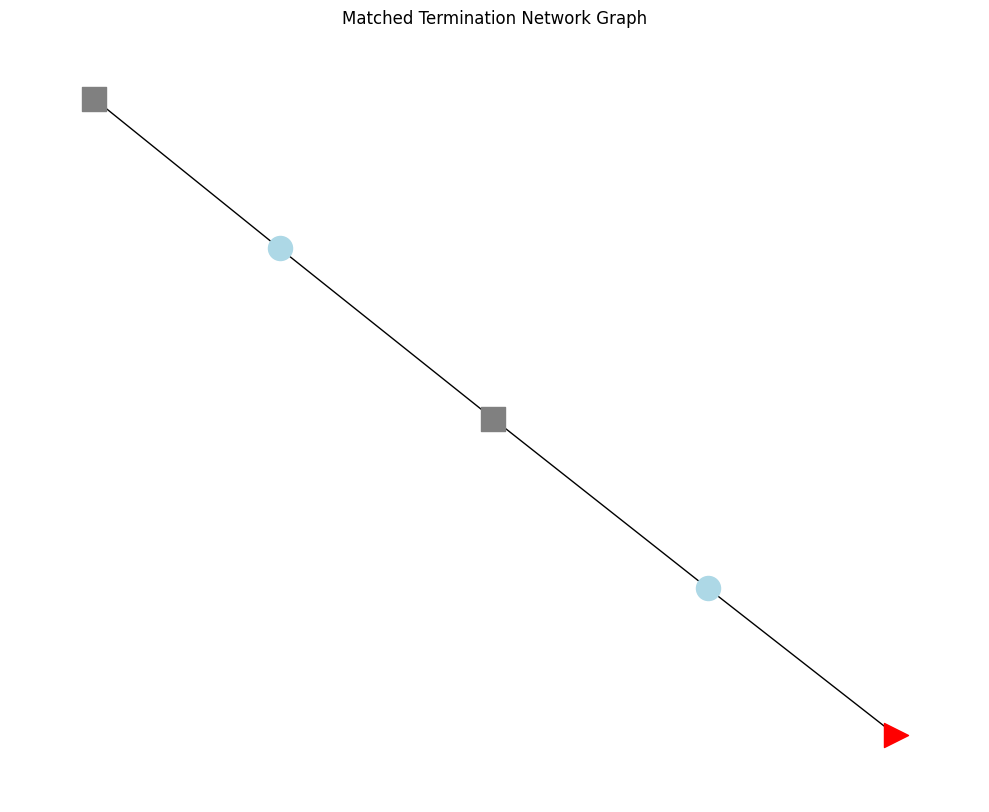

In [4]:
circuit.plot_graph()
plt.title('Matched Termination Network Graph')
plt.show()

In [5]:
# Build the network from circuit
network = circuit.network
network.name = 'Matched_Termination_Network'

# Create analyzer
analyzer = OnePortAnalyzer(network=network)

print(f"Network: {network.name}")
print(f"Frequency range: {network.f[0]/1e9:.2f} - {network.f[-1]/1e9:.2f} GHz")
print(f"Number of points: {len(network.f)}")

Network: Matched_Termination_Network
Frequency range: 0.00 - 10.00 GHz
Number of points: 101


/home/ukde/.pyenv/versions/SB/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


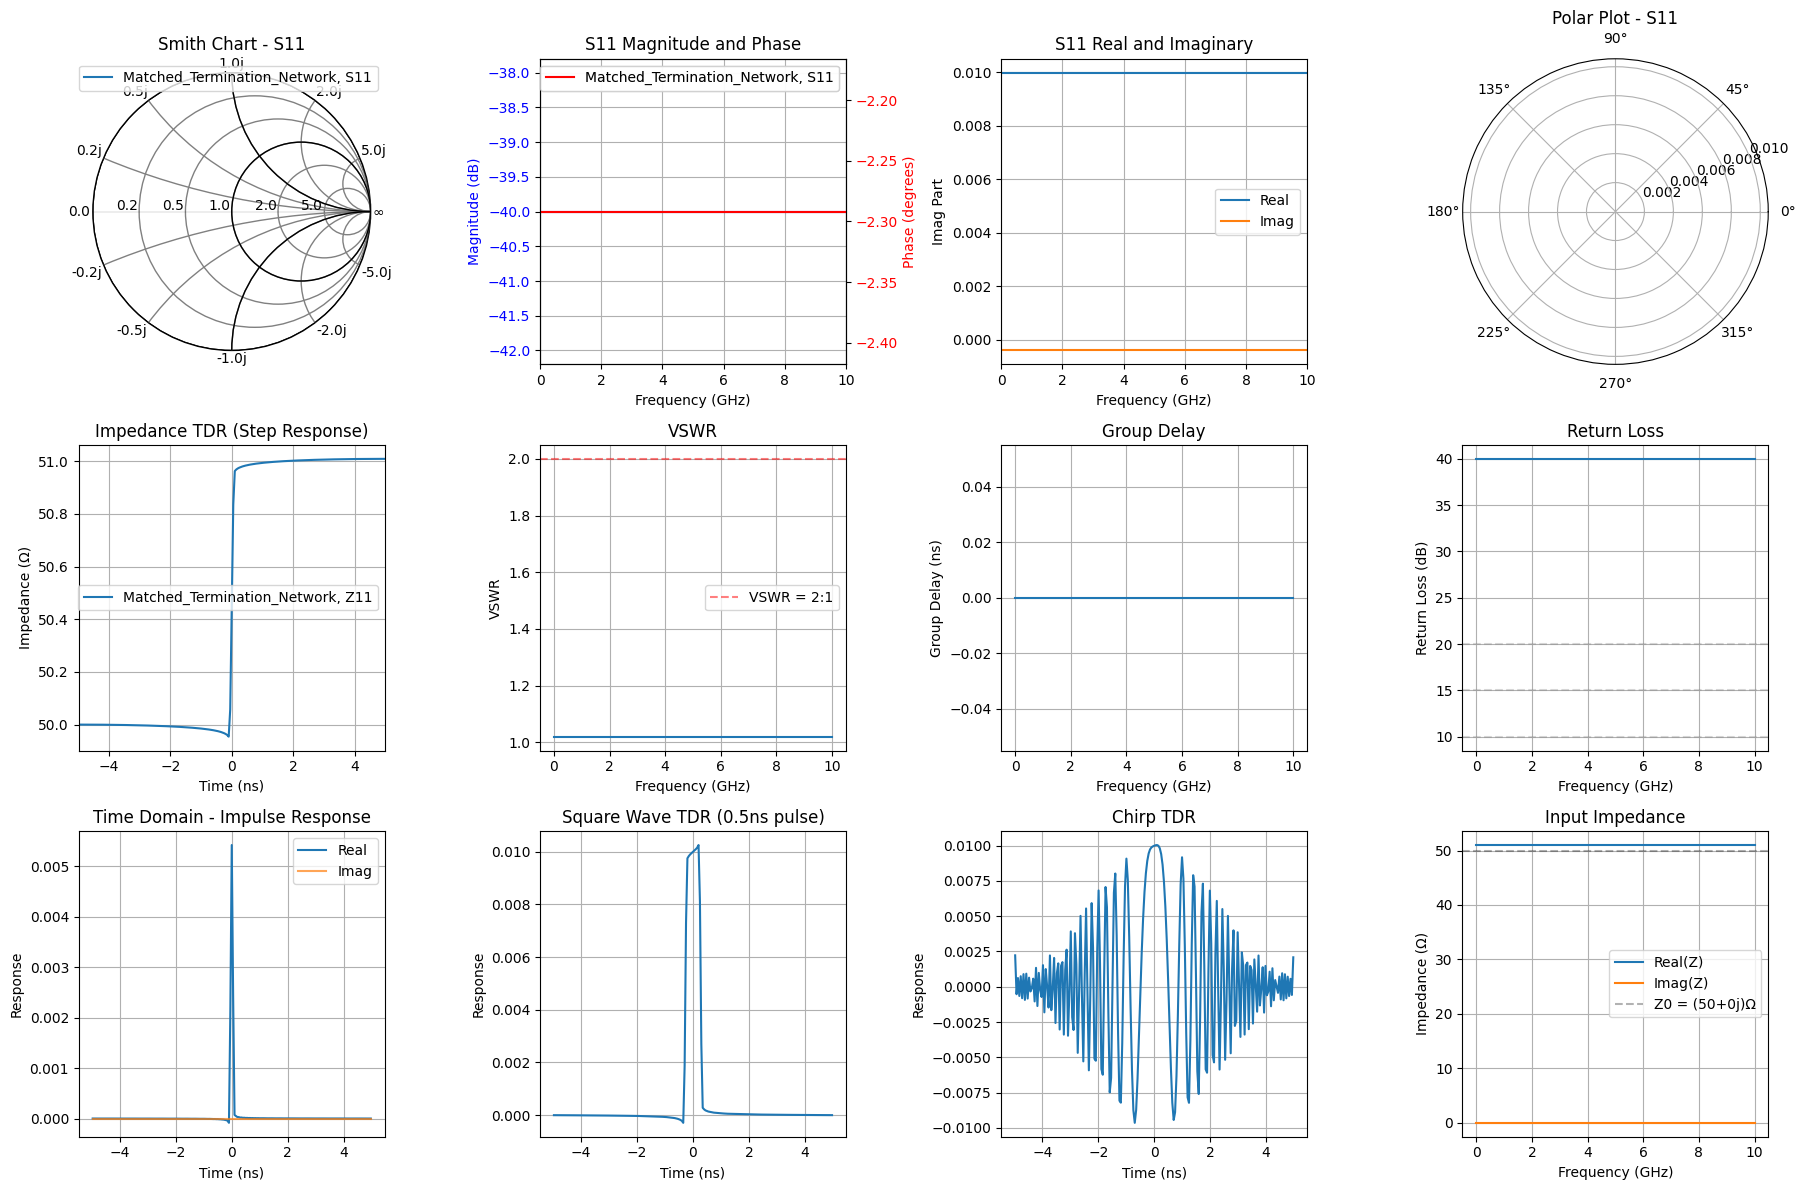

In [6]:
analyzer.plot_all()
plt.show()

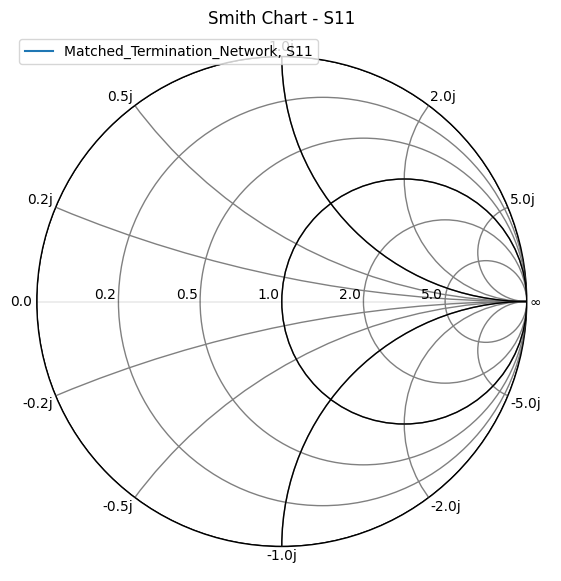

In [7]:
# Example: Plot just Smith chart
fig, ax = plt.subplots(figsize=(7, 7))
analyzer.plot_smith(ax=ax)
plt.show()

In [8]:
# Get summary
analyzer.summary()


One-Port Network Analysis: Matched_Termination_Network

Frequency Range:
  Min Frequency:     0.0000 GHz
  Max Frequency:     10.0000 GHz
  Frequency Span:    10.0000 GHz
  Number of Points:  101
  Frequency Step:    100.0000 MHz
  Z0:                50.00+0.00j Ω
  DC Extrapolated:   False

S11 Characteristics:
  Best Match (S11):  -40.00 dB @ 0.000 GHz
  Worst Match (S11): -40.00 dB @ 0.000 GHz
  Mean S11:          -40.00 dB

Return Loss:
  Best RL:           40.00 dB
  Worst RL:          40.00 dB
  Mean RL:           40.00 dB

VSWR:
  Minimum VSWR:      1.020:1
  Maximum VSWR:      1.020:1
  Mean VSWR:         1.020:1

Bandwidth (Return Loss > threshold):
  RL > 10 dB:        10.000 GHz
  RL > 15 dB:        10.000 GHz
  RL > 20 dB:        10.000 GHz

Group Delay:
  Mean:              0.000 ns


## Noise Matched load

In [9]:
# Start with our clean matched termination network
freq = rf.Frequency(start=0, stop=10, npoints=101, unit='GHz')

# Create a clean matched load (S11 = -40dB)
s11_linear = 10**(-40/20)
matched_load_clean = rf.Network(
    frequency=freq, 
    s=s11_linear * np.ones((len(freq), 1, 1)), 
    name='Clean_Matched_Load', 
    z0=50
)

# Method 1: Add magnitude and phase noise (polar) - the correct method
# mag_dev in linear units, phase_dev in degrees
noisy_load_1 = matched_load_clean.copy()
noisy_load_1.add_noise_polar(mag_dev=0.01, phase_dev=2.0)  # 1% mag, 2° phase
noisy_load_1.name = 'Noisy_Load_Polar_Small'

# Method 2: Larger noise
noisy_load_2 = matched_load_clean.copy()
noisy_load_2.add_noise_polar(mag_dev=0.05, phase_dev=5.0)  # 5% mag, 5° phase
noisy_load_2.name = 'Noisy_Load_Polar_Large'

# Method 3: Add frequency-dependent noise manually (more realistic)
# Noise increases with frequency
noisy_load_3 = matched_load_clean.copy()

for i in range(len(freq)):
    # Frequency-dependent noise (increases with frequency)
    freq_factor = (freq.f[i] / freq.f[-1])  # 0 to 1
    mag_dev = 0.005 + 0.02 * freq_factor    # 0.5% to 2.5%
    phase_dev = 1.0 + 4.0 * freq_factor      # 1° to 5°
    
    # Add random noise to each frequency point
    mag_noise = np.random.normal(0, mag_dev)
    phase_noise = np.random.normal(0, phase_dev)
    
    s_clean = noisy_load_3.s[i, 0, 0]
    mag_clean = np.abs(s_clean)
    phase_clean = np.angle(s_clean)
    
    # Add noise
    mag_noisy = mag_clean * (1 + mag_noise)
    phase_noisy = phase_clean + np.deg2rad(phase_noise)
    
    noisy_load_3.s[i, 0, 0] = mag_noisy * np.exp(1j * phase_noisy)

noisy_load_3.name = 'Noisy_Load_Freq_Dependent'

# Method 4: Manual noise in dB (if you want dB-based noise)
noisy_load_4 = matched_load_clean.copy()

for i in range(len(freq)):
    # Add noise in dB
    mag_noise_db = np.random.normal(0, 0.5)  # 0.5 dB standard deviation
    phase_noise_deg = np.random.normal(0, 5.0)  # 5° standard deviation
    
    s_clean = noisy_load_4.s[i, 0, 0]
    mag_clean_db = 20 * np.log10(np.abs(s_clean) + 1e-10)
    phase_clean = np.angle(s_clean)
    
    # Add noise
    mag_noisy_db = mag_clean_db + mag_noise_db
    mag_noisy = 10**(mag_noisy_db / 20)
    phase_noisy = phase_clean + np.deg2rad(phase_noise_deg)
    
    noisy_load_4.s[i, 0, 0] = mag_noisy * np.exp(1j * phase_noisy)

noisy_load_4.name = 'Noisy_Load_dB_Based'

print("Created 4 noisy networks:")
print(f"1. {noisy_load_1.name}: add_noise_polar (1% mag, 2° phase)")
print(f"2. {noisy_load_2.name}: add_noise_polar (5% mag, 5° phase)")
print(f"3. {noisy_load_3.name}: Frequency-dependent noise (manual)")
print(f"4. {noisy_load_4.name}: dB-based noise (manual)")

Created 4 noisy networks:
1. Noisy_Load_Polar_Small: add_noise_polar (1% mag, 2° phase)
2. Noisy_Load_Polar_Large: add_noise_polar (5% mag, 5° phase)
3. Noisy_Load_Freq_Dependent: Frequency-dependent noise (manual)
4. Noisy_Load_dB_Based: dB-based noise (manual)


In [10]:
# Create analyzers for each noisy network
analyzer_clean = OnePortAnalyzer(network=matched_load_clean)
analyzer_noisy_1 = OnePortAnalyzer(network=noisy_load_1)
analyzer_noisy_2 = OnePortAnalyzer(network=noisy_load_2)
analyzer_noisy_3 = OnePortAnalyzer(network=noisy_load_3)
analyzer_noisy_4 = OnePortAnalyzer(network=noisy_load_4)

# View summaries
analyzer_clean.summary()
print("\n")
analyzer_noisy_1.summary()
print("\n")
analyzer_noisy_2.summary()

One-Port Network Analysis: Clean_Matched_Load

Frequency Range:
  Min Frequency:     0.0000 GHz
  Max Frequency:     10.0000 GHz
  Frequency Span:    10.0000 GHz
  Number of Points:  101
  Frequency Step:    100.0000 MHz
  Z0:                50.00+0.00j Ω
  DC Extrapolated:   False

S11 Characteristics:
  Best Match (S11):  -40.00 dB @ 0.000 GHz
  Worst Match (S11): -40.00 dB @ 0.000 GHz
  Mean S11:          -40.00 dB

Return Loss:
  Best RL:           40.00 dB
  Worst RL:          40.00 dB
  Mean RL:           40.00 dB

VSWR:
  Minimum VSWR:      1.020:1
  Maximum VSWR:      1.020:1
  Mean VSWR:         1.020:1

Bandwidth (Return Loss > threshold):
  RL > 10 dB:        10.000 GHz
  RL > 15 dB:        10.000 GHz
  RL > 20 dB:        10.000 GHz

Group Delay:
  Mean:              0.000 ns


One-Port Network Analysis: Noisy_Load_Polar_Small

Frequency Range:
  Min Frequency:     0.0000 GHz
  Max Frequency:     10.0000 GHz
  Frequency Span:    10.0000 GHz
  Number of Points:  101
  Frequen

/home/ukde/.pyenv/versions/SB/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


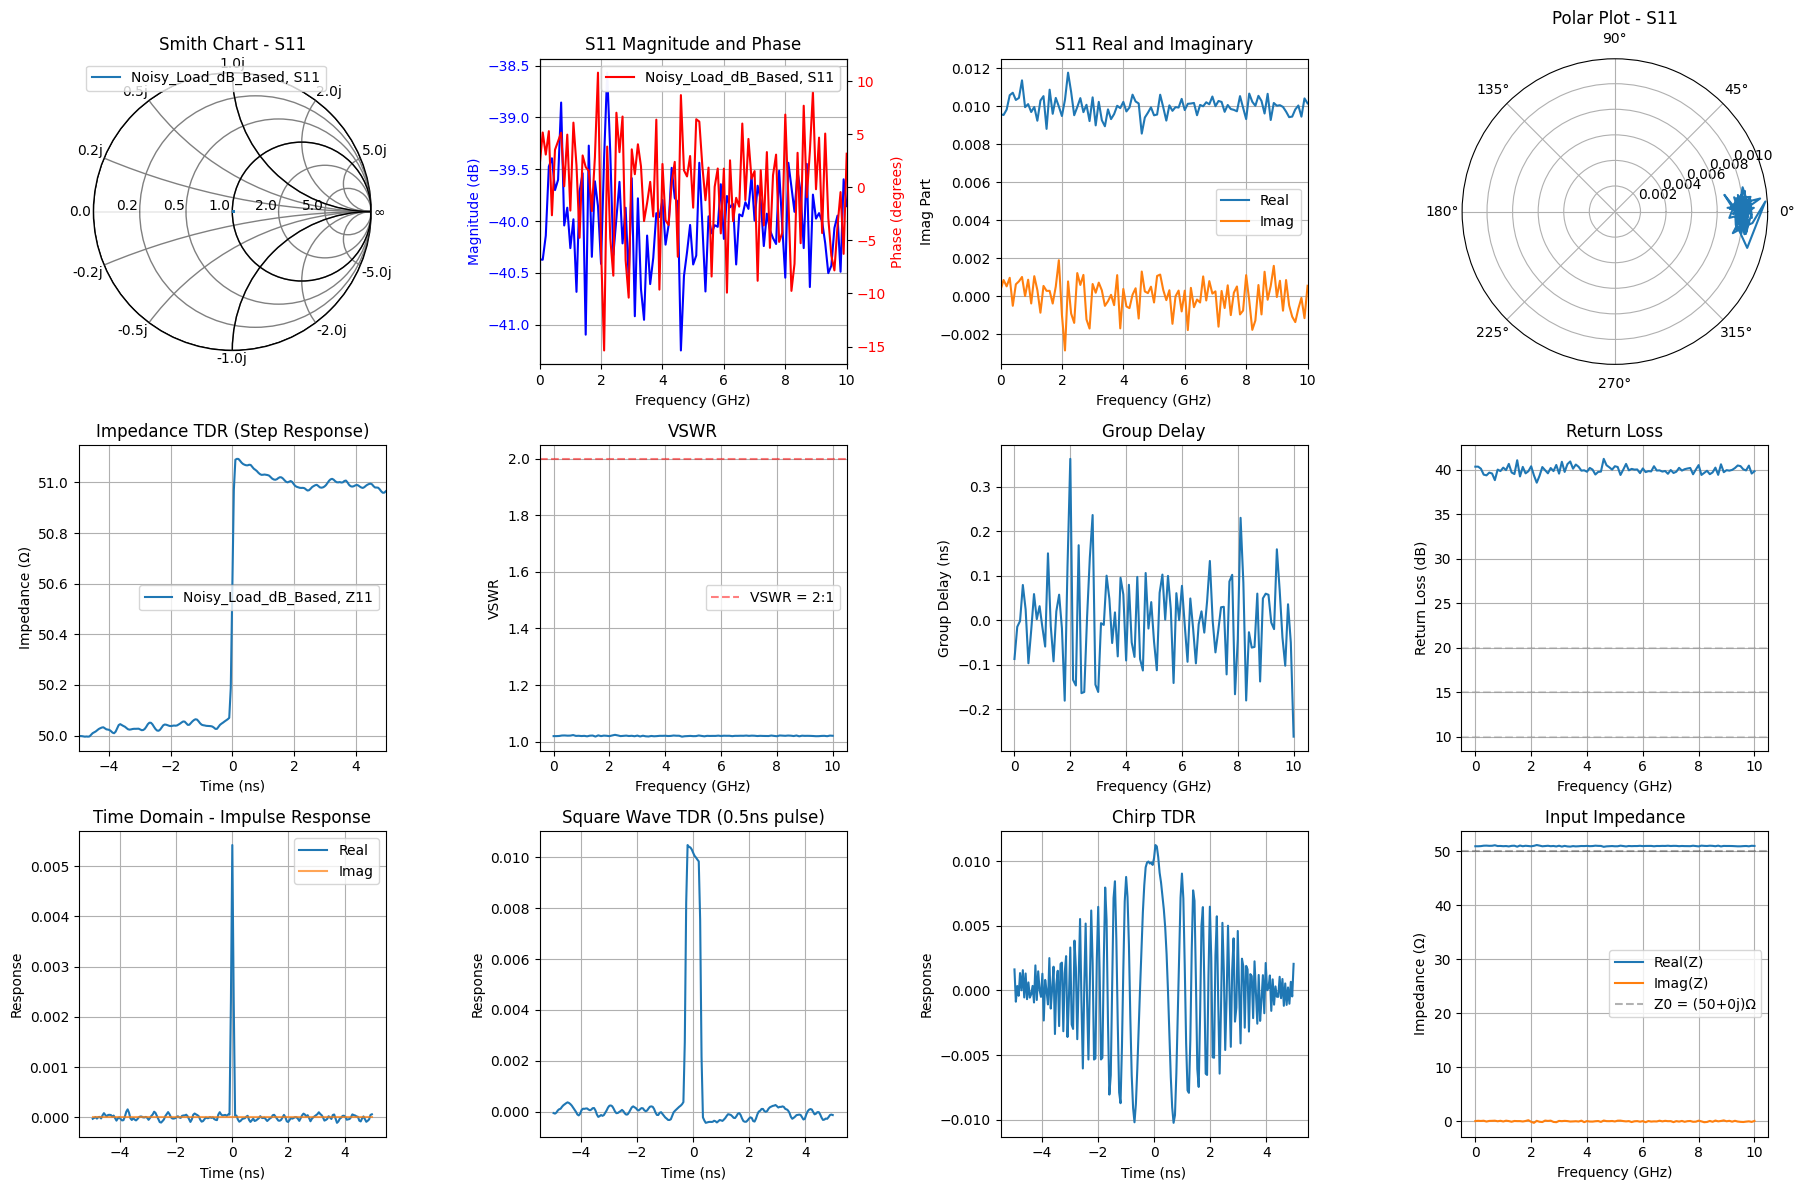

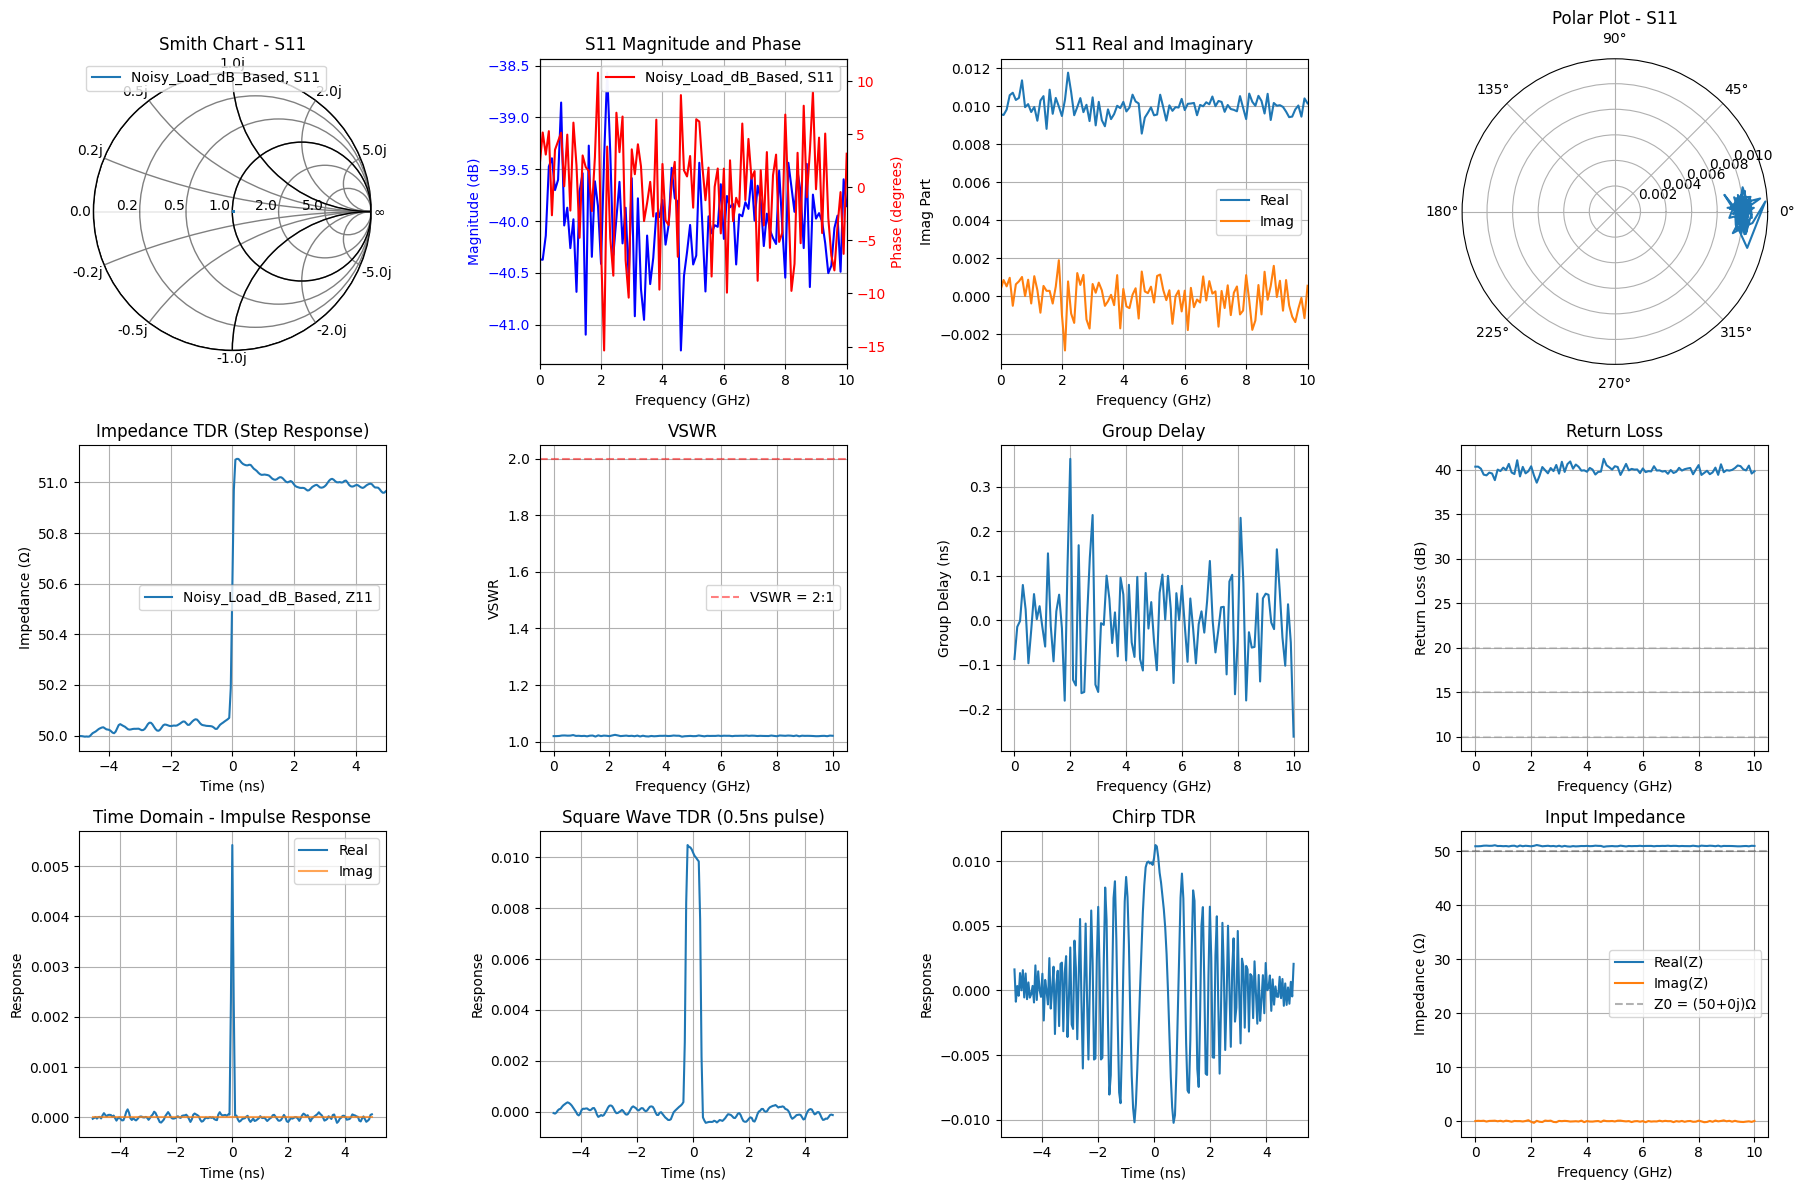

In [11]:
analyzer_noisy_4.plot_all()

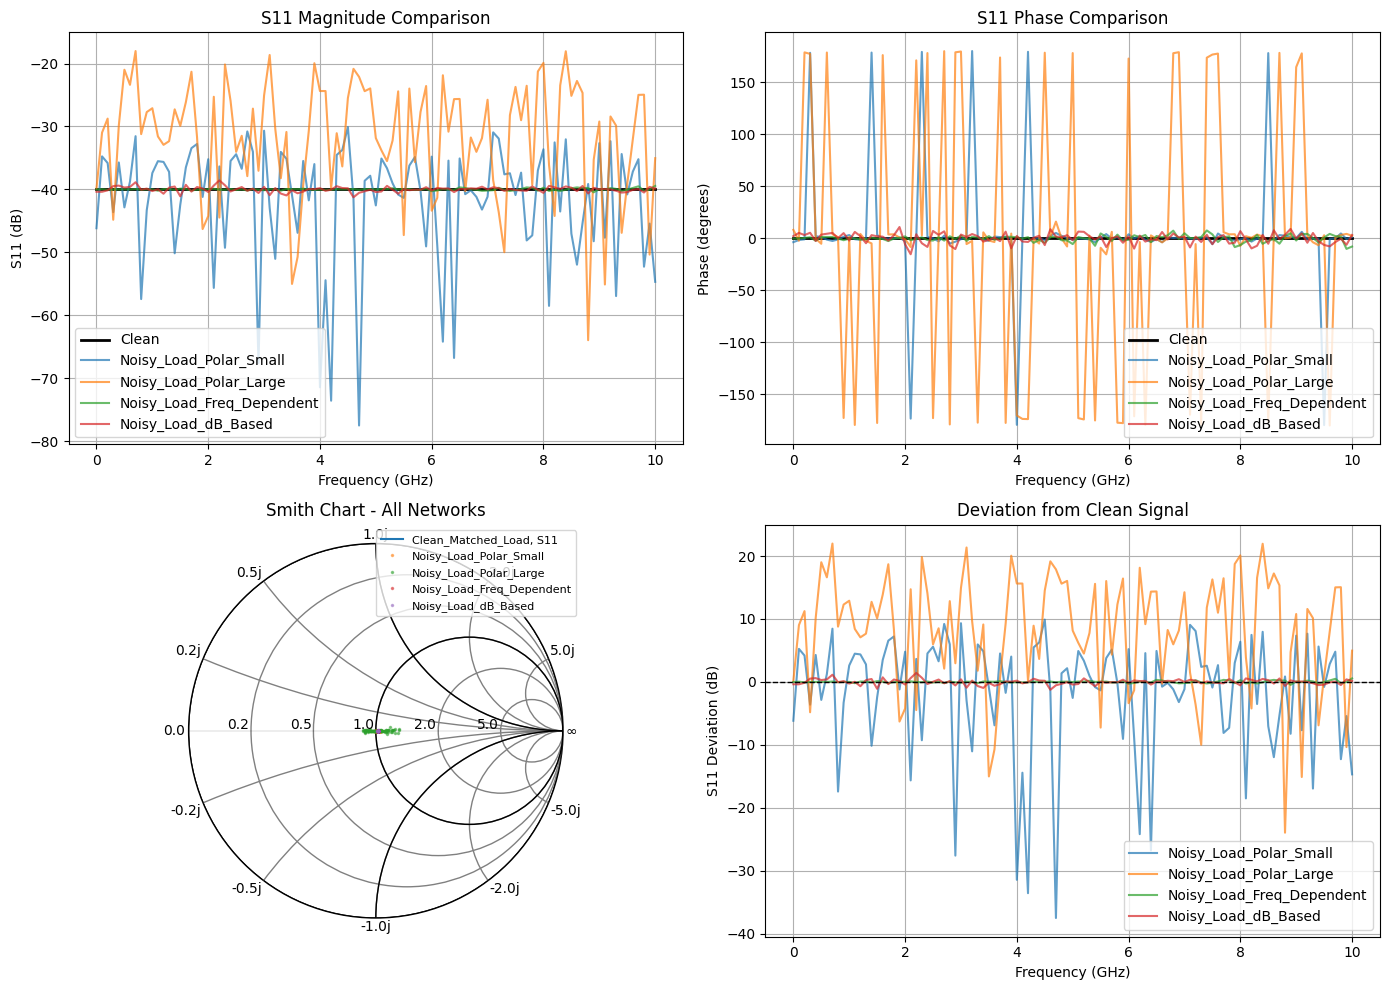

In [12]:
# Simple comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# S11 Magnitude
ax = axes[0, 0]
ax.plot(analyzer_clean.freq_ghz, analyzer_clean.s11_db, 'k-', linewidth=2, label='Clean')
ax.plot(analyzer_noisy_1.freq_ghz, analyzer_noisy_1.s11_db, alpha=0.7, label=noisy_load_1.name)
ax.plot(analyzer_noisy_2.freq_ghz, analyzer_noisy_2.s11_db, alpha=0.7, label=noisy_load_2.name)
ax.plot(analyzer_noisy_3.freq_ghz, analyzer_noisy_3.s11_db, alpha=0.7, label=noisy_load_3.name)
ax.plot(analyzer_noisy_4.freq_ghz, analyzer_noisy_4.s11_db, alpha=0.7, label=noisy_load_4.name)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('S11 (dB)')
ax.set_title('S11 Magnitude Comparison')
ax.legend()
ax.grid(True)

# S11 Phase
ax = axes[0, 1]
ax.plot(analyzer_clean.freq_ghz, analyzer_clean.s11_phase_deg, 'k-', linewidth=2, label='Clean')
ax.plot(analyzer_noisy_1.freq_ghz, analyzer_noisy_1.s11_phase_deg, alpha=0.7, label=noisy_load_1.name)
ax.plot(analyzer_noisy_2.freq_ghz, analyzer_noisy_2.s11_phase_deg, alpha=0.7, label=noisy_load_2.name)
ax.plot(analyzer_noisy_3.freq_ghz, analyzer_noisy_3.s11_phase_deg, alpha=0.7, label=noisy_load_3.name)
ax.plot(analyzer_noisy_4.freq_ghz, analyzer_noisy_4.s11_phase_deg, alpha=0.7, label=noisy_load_4.name)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Phase (degrees)')
ax.set_title('S11 Phase Comparison')
ax.legend()
ax.grid(True)

# Smith Chart
ax = axes[1, 0]
analyzer_clean.plot_smith(ax=ax)
ax.plot(analyzer_noisy_1.s11.real, analyzer_noisy_1.s11.imag, '.', alpha=0.5, markersize=3, label=noisy_load_1.name)
ax.plot(analyzer_noisy_2.s11.real, analyzer_noisy_2.s11.imag, '.', alpha=0.5, markersize=3, label=noisy_load_2.name)
ax.plot(analyzer_noisy_3.s11.real, analyzer_noisy_3.s11.imag, '.', alpha=0.5, markersize=3, label=noisy_load_3.name)
ax.plot(analyzer_noisy_4.s11.real, analyzer_noisy_4.s11.imag, '.', alpha=0.5, markersize=3, label=noisy_load_4.name)
ax.legend(loc='upper right', fontsize=8)
ax.set_title('Smith Chart - All Networks')

# Deviation from clean
ax = axes[1, 1]
deviation_1 = analyzer_noisy_1.s11_db - analyzer_clean.s11_db
deviation_2 = analyzer_noisy_2.s11_db - analyzer_clean.s11_db
deviation_3 = analyzer_noisy_3.s11_db - analyzer_clean.s11_db
deviation_4 = analyzer_noisy_4.s11_db - analyzer_clean.s11_db

ax.plot(analyzer_clean.freq_ghz, deviation_1, alpha=0.7, label=noisy_load_1.name)
ax.plot(analyzer_clean.freq_ghz, deviation_2, alpha=0.7, label=noisy_load_2.name)
ax.plot(analyzer_clean.freq_ghz, deviation_3, alpha=0.7, label=noisy_load_3.name)
ax.plot(analyzer_clean.freq_ghz, deviation_4, alpha=0.7, label=noisy_load_4.name)
ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('S11 Deviation (dB)')
ax.set_title('Deviation from Clean Signal')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

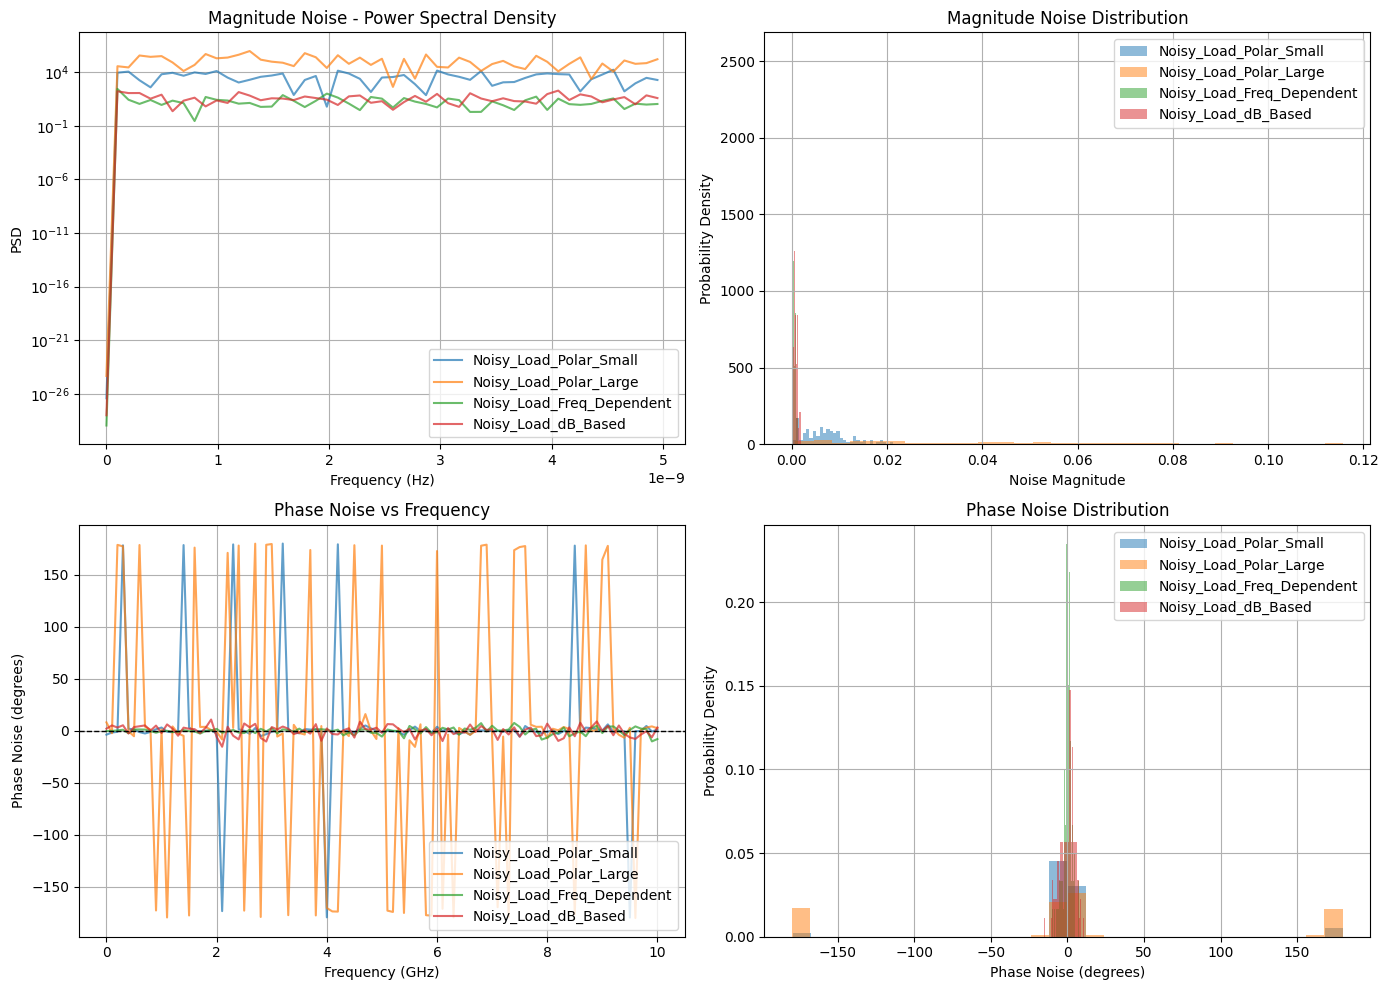

Noise Statistics:

Noisy_Load_Polar_Small:
  Magnitude Noise Std: 0.004852
  Phase Noise Std:     121.007 degrees

Noisy_Load_Polar_Large:
  Magnitude Noise Std: 0.028072
  Phase Noise Std:     128.062 degrees

Noisy_Load_Freq_Dependent:
  Magnitude Noise Std: 0.000356
  Phase Noise Std:     95.029 degrees

Noisy_Load_dB_Based:
  Magnitude Noise Std: 0.000481
  Phase Noise Std:     102.250 degrees


In [13]:
from scipy import signal

# Extract the noise (deviation from clean signal)
noise_1 = analyzer_noisy_1.s11 - analyzer_clean.s11
noise_2 = analyzer_noisy_2.s11 - analyzer_clean.s11
noise_3 = analyzer_noisy_3.s11 - analyzer_clean.s11
noise_4 = analyzer_noisy_4.s11 - analyzer_clean.s11

# Compute power spectral density of the noise
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Periodogram for magnitude noise
ax = axes[0, 0]
for i, (noise, name) in enumerate([(noise_1, noisy_load_1.name),
                                     (noise_2, noisy_load_2.name),
                                     (noise_3, noisy_load_3.name),
                                     (noise_4, noisy_load_4.name)]):
    noise_mag = np.abs(noise)
    f_psd, psd = signal.periodogram(noise_mag, fs=1/analyzer_clean.freq_step_hz)
    ax.semilogy(f_psd, psd, alpha=0.7, label=name)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')
ax.set_title('Magnitude Noise - Power Spectral Density')
ax.legend()
ax.grid(True)

# Histogram of magnitude noise
ax = axes[0, 1]
ax.hist(np.abs(noise_1), bins=30, alpha=0.5, label=noisy_load_1.name, density=True)
ax.hist(np.abs(noise_2), bins=30, alpha=0.5, label=noisy_load_2.name, density=True)
ax.hist(np.abs(noise_3), bins=30, alpha=0.5, label=noisy_load_3.name, density=True)
ax.hist(np.abs(noise_4), bins=30, alpha=0.5, label=noisy_load_4.name, density=True)
ax.set_xlabel('Noise Magnitude')
ax.set_ylabel('Probability Density')
ax.set_title('Magnitude Noise Distribution')
ax.legend()
ax.grid(True)

# Phase noise over frequency
ax = axes[1, 0]
phase_noise_1 = np.angle(analyzer_noisy_1.s11, deg=True) - np.angle(analyzer_clean.s11, deg=True)
phase_noise_2 = np.angle(analyzer_noisy_2.s11, deg=True) - np.angle(analyzer_clean.s11, deg=True)
phase_noise_3 = np.angle(analyzer_noisy_3.s11, deg=True) - np.angle(analyzer_clean.s11, deg=True)
phase_noise_4 = np.angle(analyzer_noisy_4.s11, deg=True) - np.angle(analyzer_clean.s11, deg=True)

ax.plot(analyzer_clean.freq_ghz, phase_noise_1, alpha=0.7, label=noisy_load_1.name)
ax.plot(analyzer_clean.freq_ghz, phase_noise_2, alpha=0.7, label=noisy_load_2.name)
ax.plot(analyzer_clean.freq_ghz, phase_noise_3, alpha=0.7, label=noisy_load_3.name)
ax.plot(analyzer_clean.freq_ghz, phase_noise_4, alpha=0.7, label=noisy_load_4.name)
ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Phase Noise (degrees)')
ax.set_title('Phase Noise vs Frequency')
ax.legend()
ax.grid(True)

# Histogram of phase noise
ax = axes[1, 1]
ax.hist(phase_noise_1, bins=30, alpha=0.5, label=noisy_load_1.name, density=True)
ax.hist(phase_noise_2, bins=30, alpha=0.5, label=noisy_load_2.name, density=True)
ax.hist(phase_noise_3, bins=30, alpha=0.5, label=noisy_load_3.name, density=True)
ax.hist(phase_noise_4, bins=30, alpha=0.5, label=noisy_load_4.name, density=True)
ax.set_xlabel('Phase Noise (degrees)')
ax.set_ylabel('Probability Density')
ax.set_title('Phase Noise Distribution')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

# Print noise statistics
print("Noise Statistics:")
print("="*60)
for noise, name in [(noise_1, noisy_load_1.name),
                    (noise_2, noisy_load_2.name),
                    (noise_3, noisy_load_3.name),
                    (noise_4, noisy_load_4.name)]:
    mag_std = np.std(np.abs(noise))
    phase_std = np.std(np.angle(noise, deg=True))
    print(f"\n{name}:")
    print(f"  Magnitude Noise Std: {mag_std:.6f}")
    print(f"  Phase Noise Std:     {phase_std:.3f} degrees")

In [14]:
@attrs.define
class OnePortAnalyzer:
    """Class to analyze and visualize one-port S-parameter data"""
    network: rf.Network = attrs.field()
    reference_network: Optional[rf.Network] = attrs.field(default=None)
    _dc_extrapolated: bool = attrs.field(default=False, init=False)
    
    def __attrs_post_init__(self):
        """Validate that this is a one-port network"""
        if self.network.s.shape[1:] != (1, 1):
            raise ValueError(f"Expected 1-port network, got shape {self.network.s.shape}")
        
        # Validate reference network if provided
        if self.reference_network is not None:
            if self.reference_network.s.shape[1:] != (1, 1):
                raise ValueError(f"Expected 1-port reference network, got shape {self.reference_network.s.shape}")
            
            # Check frequency compatibility
            if not np.allclose(self.network.f, self.reference_network.f):
                raise ValueError("Network and reference network must have the same frequency points")
    
    # ==================== Noise Detection ====================
    
    @property
    def has_noise_reference(self):
        """Check if noise analysis is available"""
        return self.reference_network is not None
    
    @property
    def noise(self):
        """Get noise (deviation from reference)"""
        if not self.has_noise_reference:
            raise ValueError("No reference network available for noise analysis")
        return self.s11 - self.reference_network.s[:, 0, 0]
    
    @property
    def noise_mag(self):
        """Magnitude of noise"""
        if not self.has_noise_reference:
            raise ValueError("No reference network available for noise analysis")
        return np.abs(self.noise)
    
    @property
    def noise_phase_deg(self):
        """Phase noise in degrees"""
        if not self.has_noise_reference:
            raise ValueError("No reference network available for noise analysis")
        return np.angle(self.noise, deg=True)
    
    @property
    def s11_deviation_db(self):
        """S11 deviation from reference in dB"""
        if not self.has_noise_reference:
            raise ValueError("No reference network available for noise analysis")
        ref_s11 = self.reference_network.s[:, 0, 0]
        return 20 * np.log10(np.abs(self.s11) + 1e-10) - 20 * np.log10(np.abs(ref_s11) + 1e-10)
    
    @property
    def phase_deviation_deg(self):
        """Phase deviation from reference in degrees"""
        if not self.has_noise_reference:
            raise ValueError("No reference network available for noise analysis")
        ref_s11 = self.reference_network.s[:, 0, 0]
        return np.angle(self.s11, deg=True) - np.angle(ref_s11, deg=True)
    
    # ==================== Noise Statistics ====================
    
    @property
    def noise_mag_mean(self):
        """Mean magnitude noise"""
        if not self.has_noise_reference:
            return None
        return np.mean(self.noise_mag)
    
    @property
    def noise_mag_std(self):
        """Standard deviation of magnitude noise"""
        if not self.has_noise_reference:
            return None
        return np.std(self.noise_mag)
    
    @property
    def noise_phase_mean(self):
        """Mean phase noise in degrees"""
        if not self.has_noise_reference:
            return None
        return np.mean(self.noise_phase_deg)
    
    @property
    def noise_phase_std(self):
        """Standard deviation of phase noise in degrees"""
        if not self.has_noise_reference:
            return None
        return np.std(self.noise_phase_deg)
    
    @property
    def s11_deviation_db_mean(self):
        """Mean S11 deviation in dB"""
        if not self.has_noise_reference:
            return None
        return np.mean(self.s11_deviation_db)
    
    @property
    def s11_deviation_db_std(self):
        """Standard deviation of S11 deviation in dB"""
        if not self.has_noise_reference:
            return None
        return np.std(self.s11_deviation_db)
    
    # ==================== Network Properties (unchanged) ====================
    
    @property
    def s11(self):
        """Get S11 as a 1D array"""
        return self.network.s[:, 0, 0]
    
    @property
    def freq_hz(self):
        """Frequency in Hz"""
        return self.network.f
    
    @property
    def freq_ghz(self):
        """Frequency in GHz"""
        return self.network.f / 1e9
    
    @property
    def min_freq_hz(self):
        """Minimum frequency in Hz"""
        return self.network.f[0]
    
    @property
    def max_freq_hz(self):
        """Maximum frequency in Hz"""
        return self.network.f[-1]
    
    @property
    def min_freq_ghz(self):
        """Minimum frequency in GHz"""
        return self.network.f[0] / 1e9
    
    @property
    def max_freq_ghz(self):
        """Maximum frequency in GHz"""
        return self.network.f[-1] / 1e9
    
    @property
    def freq_span_hz(self):
        """Frequency span in Hz"""
        return self.max_freq_hz - self.min_freq_hz
    
    @property
    def freq_span_ghz(self):
        """Frequency span in GHz"""
        return self.freq_span_hz / 1e9
    
    @property
    def num_points(self):
        """Number of frequency points"""
        return len(self.network.f)
    
    @property
    def freq_step_hz(self):
        """Average frequency step in Hz"""
        if self.num_points > 1:
            return self.freq_span_hz / (self.num_points - 1)
        return 0
    
    @property
    def freq_step_mhz(self):
        """Average frequency step in MHz"""
        return self.freq_step_hz / 1e6
    
    @property
    def z0(self):
        """Characteristic impedance (assumes constant Z0)"""
        return self.network.z0[0, 0]
    
    # ==================== S11 Metrics (unchanged) ====================
    
    @property
    def s11_mag(self):
        """S11 magnitude (linear)"""
        return np.abs(self.s11)
    
    @property
    def s11_db(self):
        """S11 magnitude in dB"""
        return 20 * np.log10(self.s11_mag + 1e-10)
    
    @property
    def s11_phase_deg(self):
        """S11 phase in degrees"""
        return np.angle(self.s11, deg=True)
    
    @property
    def s11_phase_rad(self):
        """S11 phase in radians"""
        return np.angle(self.s11)
    
    @property
    def s11_real(self):
        """Real part of S11"""
        return self.s11.real
    
    @property
    def s11_imag(self):
        """Imaginary part of S11"""
        return self.s11.imag
    
    @property
    def s11_min_db(self):
        """Minimum S11 in dB (best match)"""
        return np.min(self.s11_db)
    
    @property
    def s11_max_db(self):
        """Maximum S11 in dB (worst match)"""
        return np.max(self.s11_db)
    
    @property
    def s11_mean_db(self):
        """Mean S11 in dB"""
        return np.mean(self.s11_db)
    
    @property
    def freq_at_worst_match_ghz(self):
        """Frequency where S11 is maximum (worst match) in GHz"""
        idx = np.argmax(self.s11_mag)
        return self.freq_ghz[idx]
    
    @property
    def freq_at_best_match_ghz(self):
        """Frequency where S11 is minimum (best match) in GHz"""
        idx = np.argmin(self.s11_mag)
        return self.freq_ghz[idx]
    
    # ==================== Return Loss Metrics (unchanged) ====================
    
    @property
    def return_loss_db(self):
        """Return loss in dB"""
        return -self.s11_db
    
    @property
    def best_return_loss_db(self):
        """Best (maximum) return loss in dB"""
        return np.max(self.return_loss_db)
    
    @property
    def worst_return_loss_db(self):
        """Worst (minimum) return loss in dB"""
        return np.min(self.return_loss_db)
    
    @property
    def mean_return_loss_db(self):
        """Mean return loss in dB"""
        return np.mean(self.return_loss_db)
    
    # ==================== VSWR Metrics (unchanged) ====================
    
    @property
    def vswr(self):
        """VSWR across frequency"""
        return (1 + self.s11_mag) / (1 - self.s11_mag + 1e-10)
    
    @property
    def vswr_min(self):
        """Minimum VSWR (best match)"""
        return np.min(self.vswr)
    
    @property
    def vswr_max(self):
        """Maximum VSWR (worst match)"""
        return np.max(self.vswr)
    
    @property
    def vswr_mean(self):
        """Mean VSWR"""
        return np.mean(self.vswr)
    
    # ==================== Impedance Metrics (unchanged) ====================
    
    @property
    def z_in(self):
        """Input impedance across frequency"""
        return self.network.z[:, 0, 0]
    
    @property
    def z_in_real(self):
        """Real part of input impedance"""
        return self.z_in.real
    
    @property
    def z_in_imag(self):
        """Imaginary part of input impedance"""
        return self.z_in.imag
    
    @property
    def z_in_mag(self):
        """Magnitude of input impedance"""
        return np.abs(self.z_in)
    
    # ==================== Group Delay Metrics (unchanged) ====================
    
    @property
    def group_delay_s(self):
        """Group delay in seconds"""
        phase = np.unwrap(self.s11_phase_rad)
        return -np.gradient(phase) / (2 * np.pi * np.gradient(self.freq_hz))
    
    @property
    def group_delay_ns(self):
        """Group delay in nanoseconds"""
        return self.group_delay_s * 1e9
    
    @property
    def mean_group_delay_ns(self):
        """Mean group delay in ns"""
        return np.mean(self.group_delay_ns)
    
    # ==================== Utility Methods ====================
    
    def extrapolate_to_dc(self):
        """Extrapolate network to DC for proper time-domain analysis"""
        if self.network.f[0] > 0:
            print(f"Extrapolating from {self.network.f[0]/1e9:.3f} GHz to DC...")
            self.network = self.network.extrapolate_to_dc(kind='linear')
            if self.reference_network is not None and self.reference_network.f[0] > 0:
                self.reference_network = self.reference_network.extrapolate_to_dc(kind='linear')
            self._dc_extrapolated = True
            print(f"New frequency range: {self.network.f[0]/1e9:.6f} - {self.network.f[-1]/1e9:.2f} GHz")
        else:
            print("Network already starts at DC")
        return self
    
    def get_bandwidth(self, threshold_db=-10):
        """
        Get bandwidth where return loss is better than threshold
        
        Parameters
        ----------
        threshold_db : float
            Return loss threshold in dB (default: -10 dB)
        
        Returns
        -------
        bw_ghz : float
            Bandwidth in GHz where return loss > threshold_db
        """
        mask = self.return_loss_db > threshold_db
        if not np.any(mask):
            return 0.0
        
        freqs_in_band = self.freq_ghz[mask]
        return freqs_in_band[-1] - freqs_in_band[0]
    
    def summary(self):
        """Print summary of network characteristics"""
        print("=" * 60)
        print(f"One-Port Network Analysis: {self.network.name}")
        print("=" * 60)
        print(f"\nFrequency Range:")
        print(f"  Min Frequency:     {self.min_freq_ghz:.4f} GHz")
        print(f"  Max Frequency:     {self.max_freq_ghz:.4f} GHz")
        print(f"  Frequency Span:    {self.freq_span_ghz:.4f} GHz")
        print(f"  Number of Points:  {self.num_points}")
        print(f"  Frequency Step:    {self.freq_step_mhz:.4f} MHz")
        print(f"  Z0:                {self.z0:.2f} Ω")
        print(f"  DC Extrapolated:   {self._dc_extrapolated}")
        print(f"  Noise Reference:   {self.has_noise_reference}")
        
        print(f"\nS11 Characteristics:")
        print(f"  Best Match (S11):  {self.s11_min_db:.2f} dB @ {self.freq_at_best_match_ghz:.3f} GHz")
        print(f"  Worst Match (S11): {self.s11_max_db:.2f} dB @ {self.freq_at_worst_match_ghz:.3f} GHz")
        print(f"  Mean S11:          {self.s11_mean_db:.2f} dB")
        
        print(f"\nReturn Loss:")
        print(f"  Best RL:           {self.best_return_loss_db:.2f} dB")
        print(f"  Worst RL:          {self.worst_return_loss_db:.2f} dB")
        print(f"  Mean RL:           {self.mean_return_loss_db:.2f} dB")
        
        print(f"\nVSWR:")
        print(f"  Minimum VSWR:      {self.vswr_min:.3f}:1")
        print(f"  Maximum VSWR:      {self.vswr_max:.3f}:1")
        print(f"  Mean VSWR:         {self.vswr_mean:.3f}:1")
        
        print(f"\nBandwidth (Return Loss > threshold):")
        for threshold in [10, 15, 20]:
            bw = self.get_bandwidth(threshold_db=threshold)
            print(f"  RL > {threshold} dB:        {bw:.3f} GHz")
        
        print(f"\nGroup Delay:")
        print(f"  Mean:              {self.mean_group_delay_ns:.3f} ns")
        
        if self.has_noise_reference:
            print(f"\nNoise Statistics:")
            print(f"  Magnitude Noise:")
            print(f"    Mean:            {self.noise_mag_mean:.6f}")
            print(f"    Std Dev:         {self.noise_mag_std:.6f}")
            print(f"  Phase Noise:")
            print(f"    Mean:            {self.noise_phase_mean:.3f} degrees")
            print(f"    Std Dev:         {self.noise_phase_std:.3f} degrees")
            print(f"  S11 Deviation:")
            print(f"    Mean:            {self.s11_deviation_db_mean:.3f} dB")
            print(f"    Std Dev:         {self.s11_deviation_db_std:.3f} dB")
        
        print("=" * 60)
    
    # ==================== Standard Plotting Methods (unchanged) ====================
    
    def plot_smith(self, ax=None):
        """Plot Smith chart"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
        self.network.plot_s_smith(m=0, n=0, ax=ax, draw_labels=True)
        ax.set_title('Smith Chart - S11')
        return ax
    
    def plot_mag_phase(self, ax=None):
        """Plot magnitude and phase on twin axes"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        self.network.plot_s_db(m=0, n=0, ax=ax, color='blue')
        ax.set_ylabel('Magnitude (dB)', color='blue')
        ax.tick_params(axis='y', labelcolor='blue')
        ax.grid(True)
        ax.set_title('S11 Magnitude and Phase')
        
        ax_phase = ax.twinx()
        self.network.plot_s_deg(m=0, n=0, ax=ax_phase, color='red')
        ax_phase.set_ylabel('Phase (degrees)', color='red')
        ax_phase.tick_params(axis='y', labelcolor='red')
        
        return ax, ax_phase
    
    def plot_real_imag(self, ax=None):
        """Plot real and imaginary parts"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        self.network.plot_s_re(m=0, n=0, ax=ax, label='Real')
        self.network.plot_s_im(m=0, n=0, ax=ax, label='Imag')
        ax.set_title('S11 Real and Imaginary')
        ax.legend()
        ax.grid(True)
        return ax
    
    def plot_impedance_tdr(self, ax=None, window='hamming'):
        """Plot impedance TDR"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        import warnings
        if not self._dc_extrapolated and self.network.f[0] > 1e6:
            print(f"Warning: Frequency starts at {self.network.f[0]/1e9:.3f} GHz. Consider using extrapolate_to_dc() for accurate TDR.")
        
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', message='Frequency doesn.*begin from 0')
            self.network.s11.plot_z_time_step(ax=ax, window=window)
        
        ax.set_title('Impedance TDR (Step Response)')
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Impedance (Ω)')
        ax.grid(True)
        return ax
    
    def plot_vswr(self, ax=None):
        """Plot VSWR"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.plot(self.freq_ghz, self.vswr)
        ax.set_title('VSWR')
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('VSWR')
        ax.grid(True)
        ax.axhline(y=2, color='r', linestyle='--', alpha=0.5, label='VSWR = 2:1')
        ax.legend()
        return ax
    
    def plot_group_delay(self, ax=None):
        """Plot group delay"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.plot(self.freq_ghz, self.group_delay_ns)
        ax.set_title('Group Delay')
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Group Delay (ns)')
        ax.grid(True)
        return ax
    
    def plot_polar(self, ax=None):
        """Plot polar representation"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='polar'))
        
        theta = np.angle(self.s11)
        r = np.abs(self.s11)
        ax.plot(theta, r)
        ax.set_title('Polar Plot - S11')
        ax.grid(True)
        return ax
    
    def plot_impulse_response(self, ax=None, window='hamming'):
        """Plot time domain impulse response"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        time, response = self.network.s11.impulse_response(window=window)
        time_ns = time * 1e9
        
        ax.plot(time_ns, response.real, label='Real')
        ax.plot(time_ns, response.imag, label='Imag', alpha=0.7)
        ax.set_title('Time Domain - Impulse Response')
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Response')
        ax.legend()
        ax.grid(True)
        return ax
    
    def plot_return_loss(self, ax=None):
        """Plot return loss"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.plot(self.freq_ghz, self.return_loss_db)
        ax.set_title('Return Loss')
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Return Loss (dB)')
        ax.grid(True)
        
        for rl in [10, 15, 20]:
            ax.axhline(y=rl, color='gray', linestyle='--', alpha=0.3)
        
        return ax
    
    def plot_square_wave_tdr(self, ax=None, pulse_width_ns=0.5, window='hamming'):
        """Plot square wave TDR response"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        time, impulse = self.network.s11.impulse_response(window=window)
        time_ns = time * 1e9
        
        pulse_width = pulse_width_ns * 1e-9
        square_wave = np.zeros_like(time)
        square_wave[np.abs(time) < pulse_width/2] = 1.0
        
        square_response = np.convolve(square_wave, impulse, mode='same')
        
        ax.plot(time_ns, square_response.real)
        ax.set_title(f'Square Wave TDR ({pulse_width_ns}ns pulse)')
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Response')
        ax.grid(True)
        return ax
    
    def plot_chirp_tdr(self, ax=None, window='hamming'):
        """Plot chirp TDR response"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        time, impulse = self.network.s11.impulse_response(window=window)
        time_ns = time * 1e9
        
        f0 = self.network.f[0]
        f1 = self.network.f[-1]
        chirp_signal = scipy_chirp(time, f0=f0, f1=f1, t1=time[-1], method='linear')
        
        chirp_response = np.convolve(chirp_signal, impulse, mode='same')
        
        ax.plot(time_ns, chirp_response.real)
        ax.set_title('Chirp TDR')
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Response')
        ax.grid(True)
        return ax
    
    def plot_impedance(self, ax=None):
        """Plot input impedance (real and imaginary)"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.plot(self.freq_ghz, self.z_in_real, label='Real(Z)')
        ax.plot(self.freq_ghz, self.z_in_imag, label='Imag(Z)')
        ax.axhline(y=self.z0, color='k', linestyle='--', alpha=0.3, label=f'Z0 = {self.z0}Ω')
        ax.set_title('Input Impedance')
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Impedance (Ω)')
        ax.legend()
        ax.grid(True)
        return ax
    
    # ==================== Noise-Specific Plotting Methods ====================
    
    def plot_noise_deviation(self, ax=None):
        """Plot S11 deviation from reference"""
        if not self.has_noise_reference:
            raise ValueError("No reference network available for noise analysis")
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.plot(self.freq_ghz, self.s11_deviation_db)
        ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('S11 Deviation (dB)')
        ax.set_title('S11 Deviation from Reference')
        ax.grid(True)
        return ax
    
    def plot_phase_deviation(self, ax=None):
        """Plot phase deviation from reference"""
        if not self.has_noise_reference:
            raise ValueError("No reference network available for noise analysis")
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.plot(self.freq_ghz, self.phase_deviation_deg)
        ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Phase Deviation (degrees)')
        ax.set_title('Phase Deviation from Reference')
        ax.grid(True)
        return ax
    
    def plot_noise_magnitude_histogram(self, ax=None, bins=30):
        """Plot histogram of magnitude noise"""
        if not self.has_noise_reference:
            raise ValueError("No reference network available for noise analysis")
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.hist(self.noise_mag, bins=bins, density=True, alpha=0.7, edgecolor='black')
        ax.set_xlabel('Noise Magnitude')
        ax.set_ylabel('Probability Density')
        ax.set_title('Magnitude Noise Distribution')
        ax.grid(True, alpha=0.3)
        
        # Add statistics text
        textstr = f'Mean: {self.noise_mag_mean:.6f}\nStd: {self.noise_mag_std:.6f}'
        ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        return ax
    
    def plot_noise_phase_histogram(self, ax=None, bins=30):
        """Plot histogram of phase noise"""
        if not self.has_noise_reference:
            raise ValueError("No reference network available for noise analysis")
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.hist(self.noise_phase_deg, bins=bins, density=True, alpha=0.7, edgecolor='black')
        ax.set_xlabel('Phase Noise (degrees)')
        ax.set_ylabel('Probability Density')
        ax.set_title('Phase Noise Distribution')
        ax.grid(True, alpha=0.3)
        
        # Add statistics text
        textstr = f'Mean: {self.noise_phase_mean:.3f}°\nStd: {self.noise_phase_std:.3f}°'
        ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        return ax
    
    def plot_noise_psd(self, ax=None):
        """Plot power spectral density of magnitude noise"""
        if not self.has_noise_reference:
            raise ValueError("No reference network available for noise analysis")
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
        
        from scipy import signal
        
        f_psd, psd = signal.periodogram(self.noise_mag, fs=1/self.freq_step_hz)
        
        ax.semilogy(f_psd, psd)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('PSD')
        ax.set_title('Magnitude Noise - Power Spectral Density')
        ax.grid(True)
        return ax
    
    def plot_smith_with_reference(self, ax=None):
        """Plot Smith chart with reference network overlay"""
        if not self.has_noise_reference:
            raise ValueError("No reference network available for noise analysis")
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(7, 7))
        
        # Plot reference
        ref_s11 = self.reference_network.s[:, 0, 0]
        self.reference_network.plot_s_smith(m=0, n=0, ax=ax, draw_labels=True, 
                                           color='black', linewidth=2, label='Reference')
        
        # Plot noisy
        ax.plot(self.s11.real, self.s11.imag, '.', alpha=0.5, markersize=4, label='Noisy')
        
        ax.set_title('Smith Chart - Reference vs Noisy')
        ax.legend(loc='upper right')
        return ax
    
    # ==================== Group Plot Methods ====================
    
    def plot_all(self, figsize=(18, 12)):
        """Create comprehensive plot with all standard visualizations (no noise)"""
        fig = plt.figure(figsize=figsize)
        
        # Row 1
        ax1 = plt.subplot(3, 4, 1)
        self.plot_smith(ax=ax1)
        
        ax2 = plt.subplot(3, 4, 2)
        self.plot_mag_phase(ax=ax2)
        
        ax3 = plt.subplot(3, 4, 3)
        self.plot_real_imag(ax=ax3)
        
        ax4 = plt.subplot(3, 4, 4, projection='polar')
        self.plot_polar(ax=ax4)
        
        # Row 2
        ax5 = plt.subplot(3, 4, 5)
        self.plot_impedance_tdr(ax=ax5)
        
        ax6 = plt.subplot(3, 4, 6)
        self.plot_vswr(ax=ax6)
        
        ax7 = plt.subplot(3, 4, 7)
        self.plot_group_delay(ax=ax7)
        
        ax8 = plt.subplot(3, 4, 8)
        self.plot_return_loss(ax=ax8)
        
        # Row 3
        ax9 = plt.subplot(3, 4, 9)
        self.plot_impulse_response(ax=ax9)
        
        ax10 = plt.subplot(3, 4, 10)
        self.plot_square_wave_tdr(ax=ax10)
        
        ax11 = plt.subplot(3, 4, 11)
        self.plot_chirp_tdr(ax=ax11)
        
        ax12 = plt.subplot(3, 4, 12)
        self.plot_impedance(ax=ax12)
        
        plt.tight_layout()
        return fig
    
    def plot_all_with_noise(self, figsize=(18, 14)):
        """Create comprehensive plot including noise analysis"""
        if not self.has_noise_reference:
            raise ValueError("No reference network available. Use plot_all() instead.")
        
        fig = plt.figure(figsize=figsize)
        
        # Row 1 - Standard plots with reference overlay
        ax1 = plt.subplot(4, 4, 1)
        self.plot_smith_with_reference(ax=ax1)
        
        ax2 = plt.subplot(4, 4, 2)
        ref_s11_db = 20 * np.log10(np.abs(self.reference_network.s[:, 0, 0]) + 1e-10)
        ax2.plot(self.freq_ghz, ref_s11_db, 'k-', linewidth=2, label='Reference')
        ax2.plot(self.freq_ghz, self.s11_db, 'b-', alpha=0.7, label='Noisy')
        ax2.set_xlabel('Frequency (GHz)')
        ax2.set_ylabel('S11 (dB)')
        ax2.set_title('S11 Magnitude')
        ax2.legend()
        ax2.grid(True)
        
        ax3 = plt.subplot(4, 4, 3)
        ref_phase = np.angle(self.reference_network.s[:, 0, 0], deg=True)
        ax3.plot(self.freq_ghz, ref_phase, 'k-', linewidth=2, label='Reference')
        ax3.plot(self.freq_ghz, self.s11_phase_deg, 'r-', alpha=0.7, label='Noisy')
        ax3.set_xlabel('Frequency (GHz)')
        ax3.set_ylabel('Phase (degrees)')
        ax3.set_title('S11 Phase')
        ax3.legend()
        ax3.grid(True)
        
        ax4 = plt.subplot(4, 4, 4)
        self.plot_vswr(ax=ax4)
        
        # Row 2 - Noise deviation plots
        ax5 = plt.subplot(4, 4, 5)
        self.plot_noise_deviation(ax=ax5)
        
        ax6 = plt.subplot(4, 4, 6)
        self.plot_phase_deviation(ax=ax6)
        
        ax7 = plt.subplot(4, 4, 7)
        self.plot_noise_magnitude_histogram(ax=ax7)
        
        ax8 = plt.subplot(4, 4, 8)
        self.plot_noise_phase_histogram(ax=ax8)
        
        # Row 3 - Additional noise analysis
        ax9 = plt.subplot(4, 4, 9)
        self.plot_noise_psd(ax=ax9)
        
        ax10 = plt.subplot(4, 4, 10)
        self.plot_return_loss(ax=ax10)
        
        ax11 = plt.subplot(4, 4, 11)
        self.plot_group_delay(ax=ax11)
        
        ax12 = plt.subplot(4, 4, 12)
        self.plot_impedance(ax=ax12)
        
        # Row 4 - Time domain
        ax13 = plt.subplot(4, 4, 13)
        self.plot_impedance_tdr(ax=ax13)
        
        ax14 = plt.subplot(4, 4, 14)
        self.plot_impulse_response(ax=ax14)
        
        ax15 = plt.subplot(4, 4, 15)
        self.plot_square_wave_tdr(ax=ax15)
        
        ax16 = plt.subplot(4, 4, 16)
        self.plot_chirp_tdr(ax=ax16)
        
        plt.tight_layout()
        return fig

print("OnePortAnalyzer class with noise analysis loaded successfully!")

OnePortAnalyzer class with noise analysis loaded successfully!


In [15]:
# Clean network
analyzer_clean = OnePortAnalyzer(network=matched_load_clean)

# Noisy network WITHOUT noise reference (standard analysis only)
analyzer_noisy_basic = OnePortAnalyzer(network=noisy_load_1)

# Noisy network WITH noise reference (full noise analysis available)
analyzer_noisy_with_ref = OnePortAnalyzer(
    network=noisy_load_3,
    reference_network=matched_load_clean
)

# Check capabilities
print(f"Clean analyzer has noise reference: {analyzer_clean.has_noise_reference}")
print(f"Noisy basic analyzer has noise reference: {analyzer_noisy_basic.has_noise_reference}")
print(f"Noisy with ref analyzer has noise reference: {analyzer_noisy_with_ref.has_noise_reference}")

Clean analyzer has noise reference: False
Noisy basic analyzer has noise reference: False
Noisy with ref analyzer has noise reference: True


/home/ukde/.pyenv/versions/SB/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


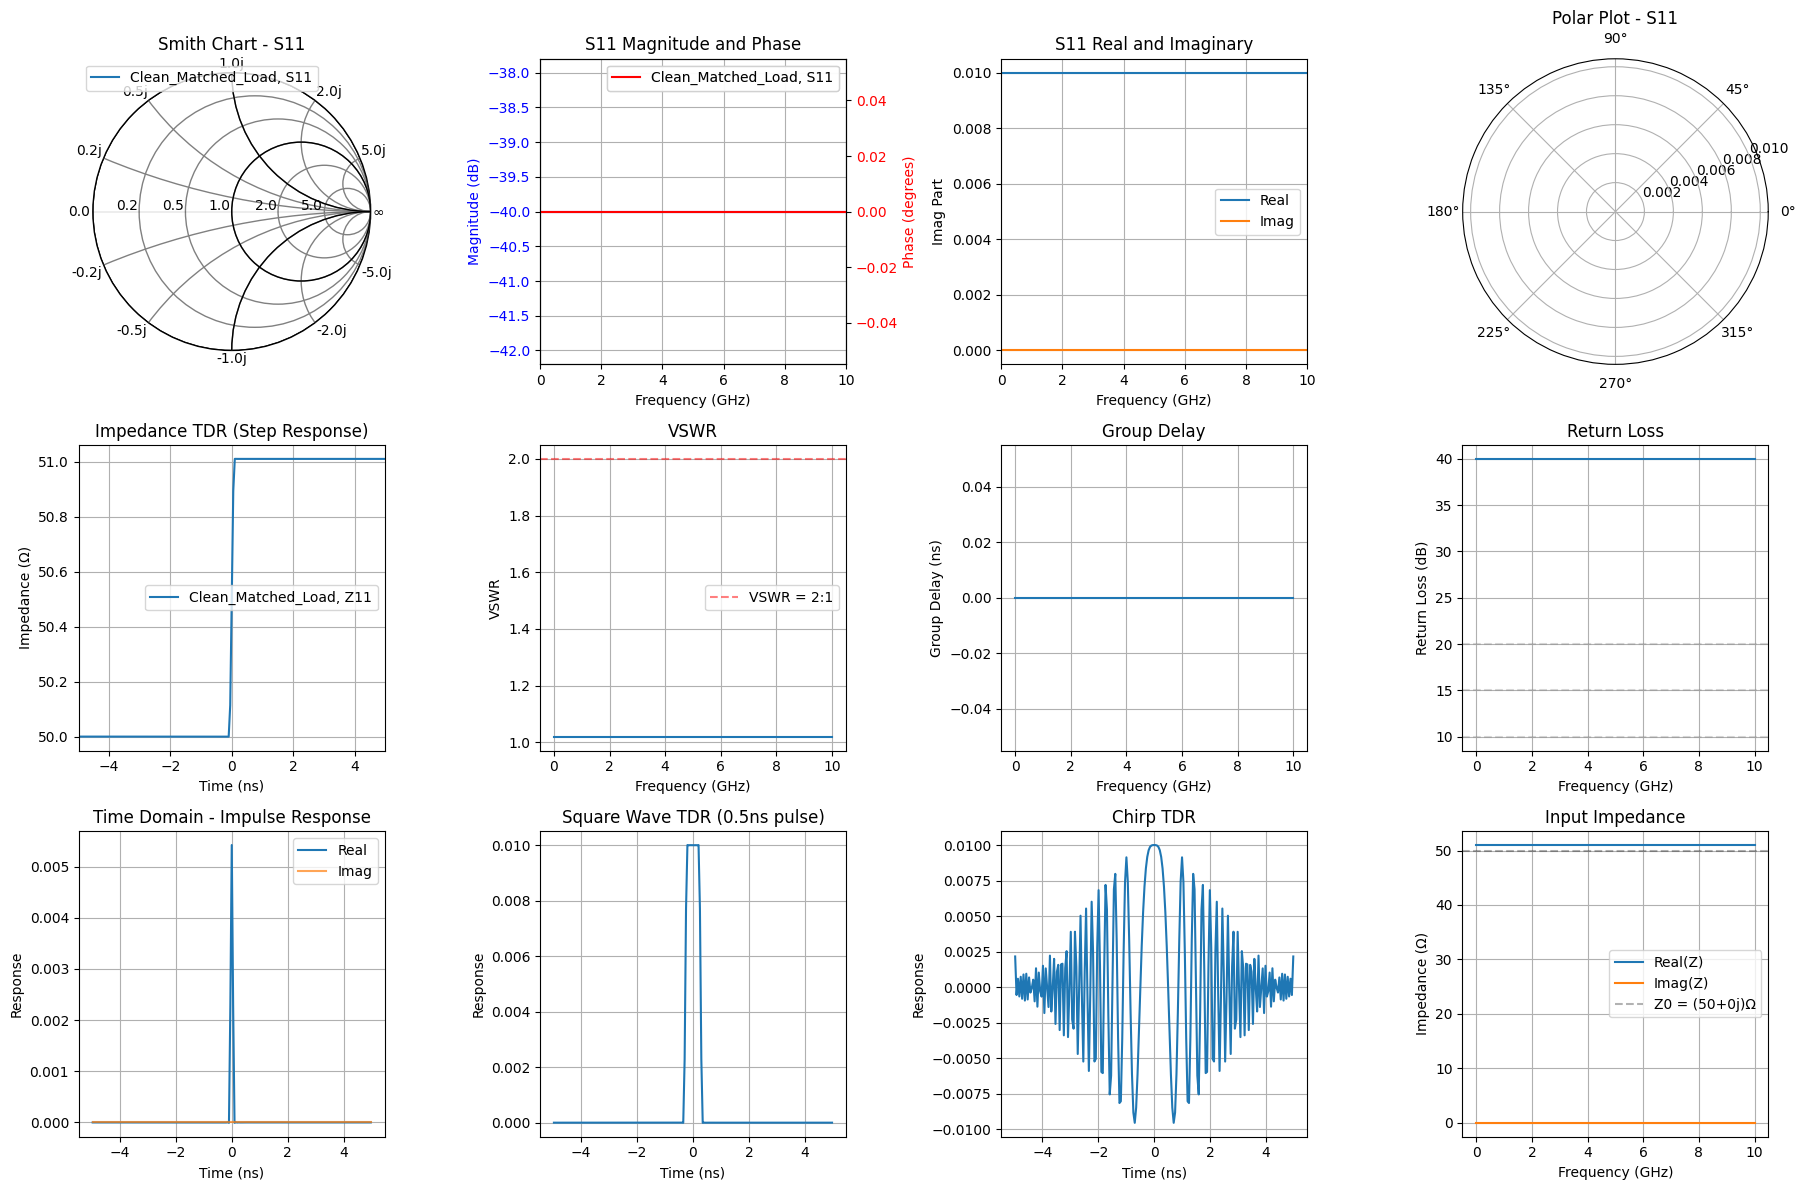

In [16]:
analyzer_clean.plot_all()
plt.show()

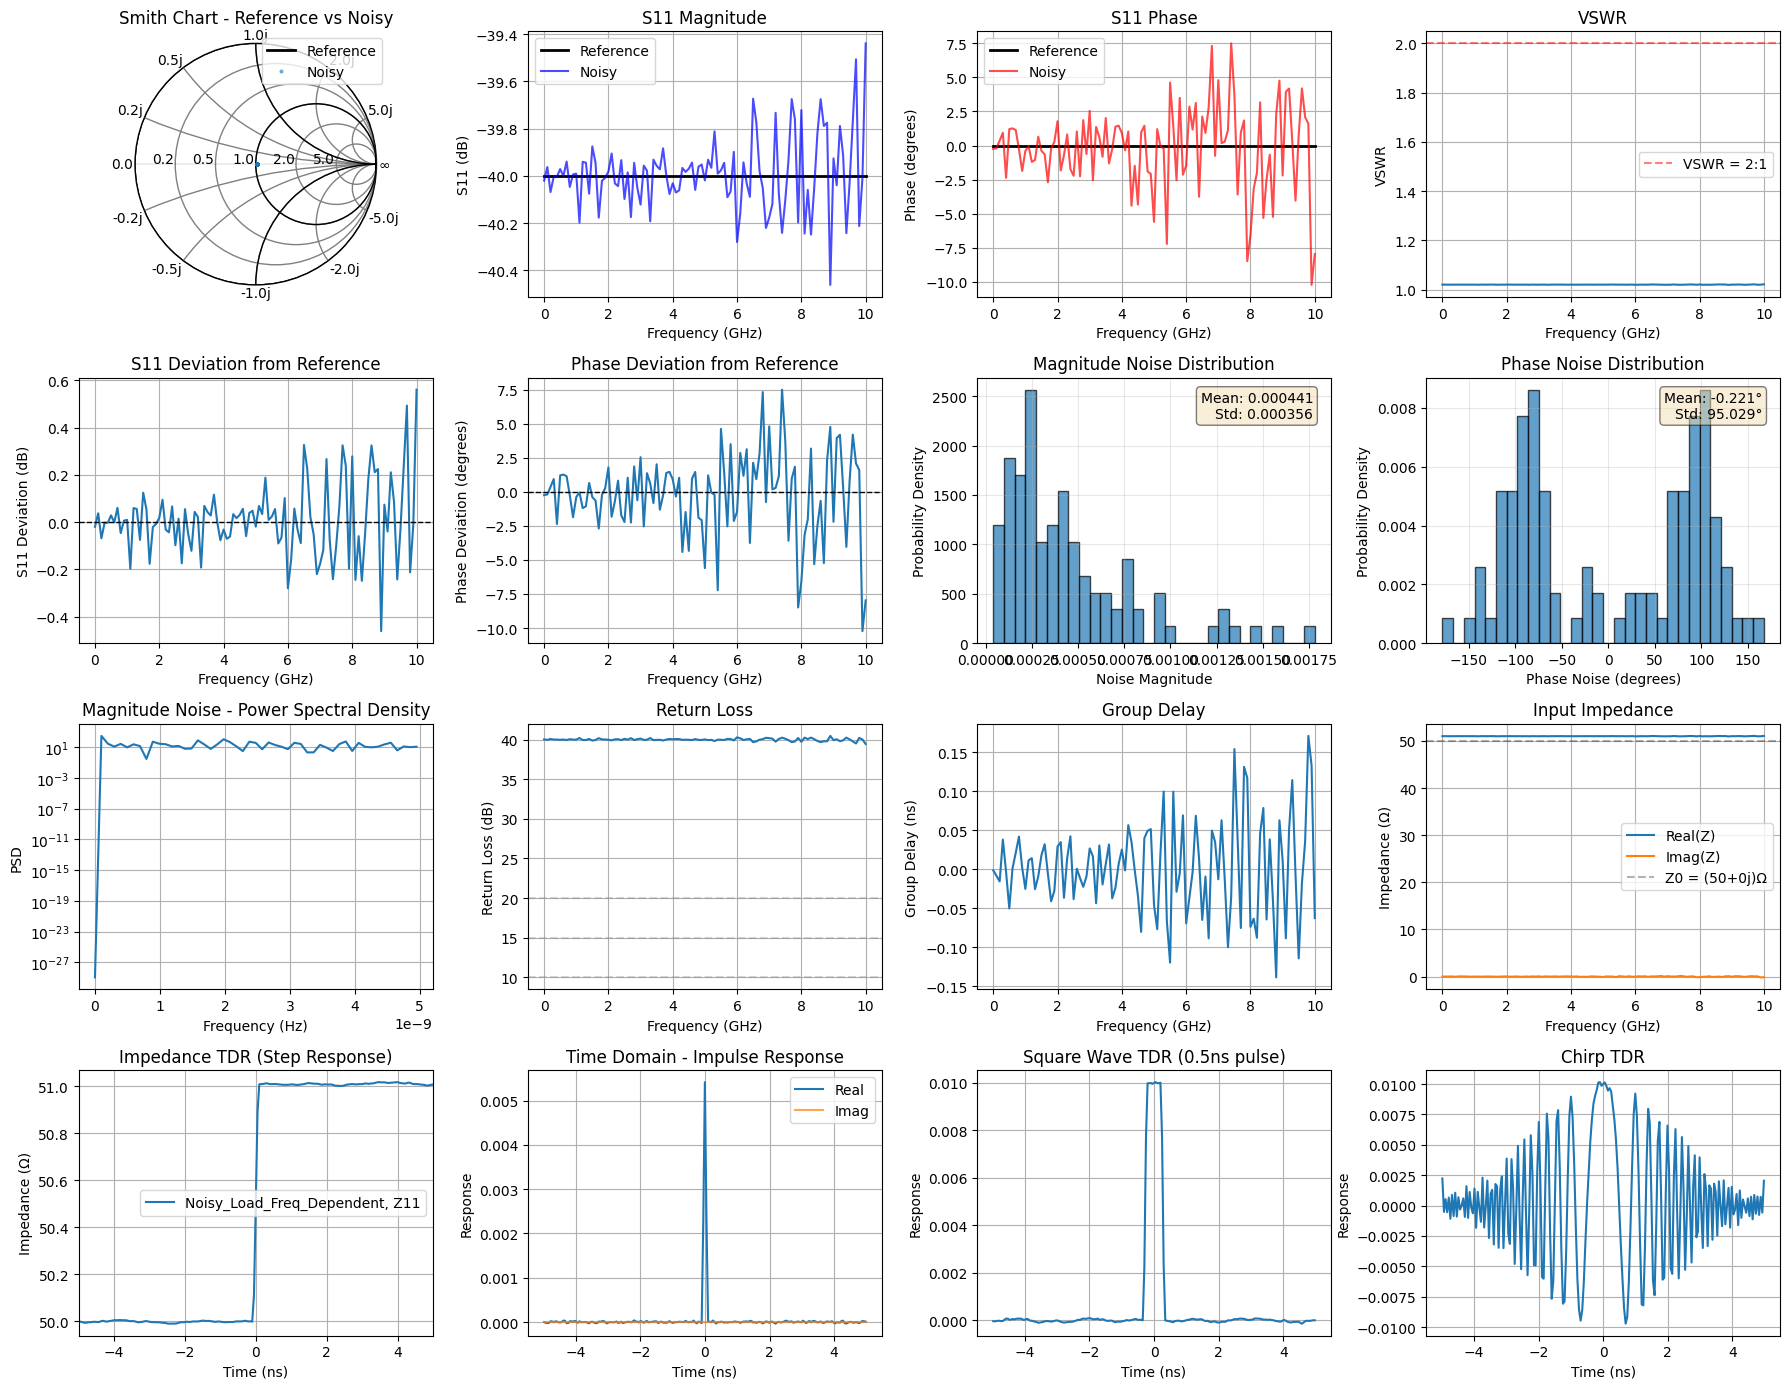

In [17]:
analyzer_noisy_with_ref.plot_all_with_noise()
plt.show()

In [18]:
analyzer_noisy_with_ref.summary()

One-Port Network Analysis: Noisy_Load_Freq_Dependent

Frequency Range:
  Min Frequency:     0.0000 GHz
  Max Frequency:     10.0000 GHz
  Frequency Span:    10.0000 GHz
  Number of Points:  101
  Frequency Step:    100.0000 MHz
  Z0:                50.00+0.00j Ω
  DC Extrapolated:   False
  Noise Reference:   True

S11 Characteristics:
  Best Match (S11):  -40.46 dB @ 8.900 GHz
  Worst Match (S11): -39.44 dB @ 10.000 GHz
  Mean S11:          -39.99 dB

Return Loss:
  Best RL:           40.46 dB
  Worst RL:          39.44 dB
  Mean RL:           39.99 dB

VSWR:
  Minimum VSWR:      1.019:1
  Maximum VSWR:      1.022:1
  Mean VSWR:         1.020:1

Bandwidth (Return Loss > threshold):
  RL > 10 dB:        10.000 GHz
  RL > 15 dB:        10.000 GHz
  RL > 20 dB:        10.000 GHz

Group Delay:
  Mean:              0.002 ns

Noise Statistics:
  Magnitude Noise:
    Mean:            0.000441
    Std Dev:         0.000356
  Phase Noise:
    Mean:            -0.221 degrees
    Std Dev:       

# Network Set of vaying load impedacnce (real an img)

In [19]:
from skrf import NetworkSet

# Define frequency range
freq = rf.Frequency(start=0, stop=10, npoints=101, unit='GHz')

# Define impedance sweep parameters
# Resistance sweep: 25Ω to 100Ω
resistances = np.array([25, 37.5, 50, 62.5, 75, 100])

# Reactance sweep: -50Ω (capacitive) to +50Ω (inductive) through 0 (resistive)
reactances = np.array([-50, -30, -15, 0, 15, 30, 50])

# Create networks for all combinations
networks = []

for R in resistances:
    for X in reactances:
        # Create load impedance
        Z_load = R + 1j * X
        
        # Convert impedance to S-parameters (1-port)
        # S11 = (Z_load - Z0) / (Z_load + Z0)
        Z0 = 50
        s11 = (Z_load - Z0) / (Z_load + Z0)
        
        # Create network
        load = rf.Network(
            frequency=freq,
            s=s11 * np.ones((len(freq), 1, 1)),
            name=f'Load_R{R:.1f}_X{X:.1f}',
            z0=Z0
        )
        
        # Store parameters for later access
        load.params = {'R': R, 'X': X, 'Z_mag': np.abs(Z_load), 'Z_phase': np.angle(Z_load, deg=True)}
        
        networks.append(load)

# Create NetworkSet
network_set = NetworkSet(networks)

print(f"Created NetworkSet with {len(networks)} networks")
print(f"Resistances: {resistances} Ω")
print(f"Reactances: {reactances} Ω")
print(f"Total combinations: {len(resistances)} × {len(reactances)} = {len(networks)}")

Created NetworkSet with 42 networks
Resistances: [ 25.   37.5  50.   62.5  75.  100. ] Ω
Reactances: [-50 -30 -15   0  15  30  50] Ω
Total combinations: 6 × 7 = 42


In [20]:
# Create networks with transmission line for each load
networks_with_tline = []

transmission_line_media = rf.media.DefinedGammaZ0(frequency=freq, z0=50)
tline = transmission_line_media.line(d=2, unit='cm', name='TLine')

for load in networks:
    # Build circuit
    port1 = rf.Circuit.Port(frequency=freq, name='port1', z0=50)
    
    connections = [
        [(port1, 0), (tline, 0)],
        [(tline, 1), (load, 0)]
    ]
    
    circuit = rf.Circuit(connections)
    system = circuit.network
    system.name = f"System_{load.name}"
    system.params = load.params.copy()
    
    networks_with_tline.append(system)

network_set_with_tline = NetworkSet(networks_with_tline)

print(f"Created NetworkSet with transmission lines: {len(networks_with_tline)} networks")

Created NetworkSet with transmission lines: 42 networks


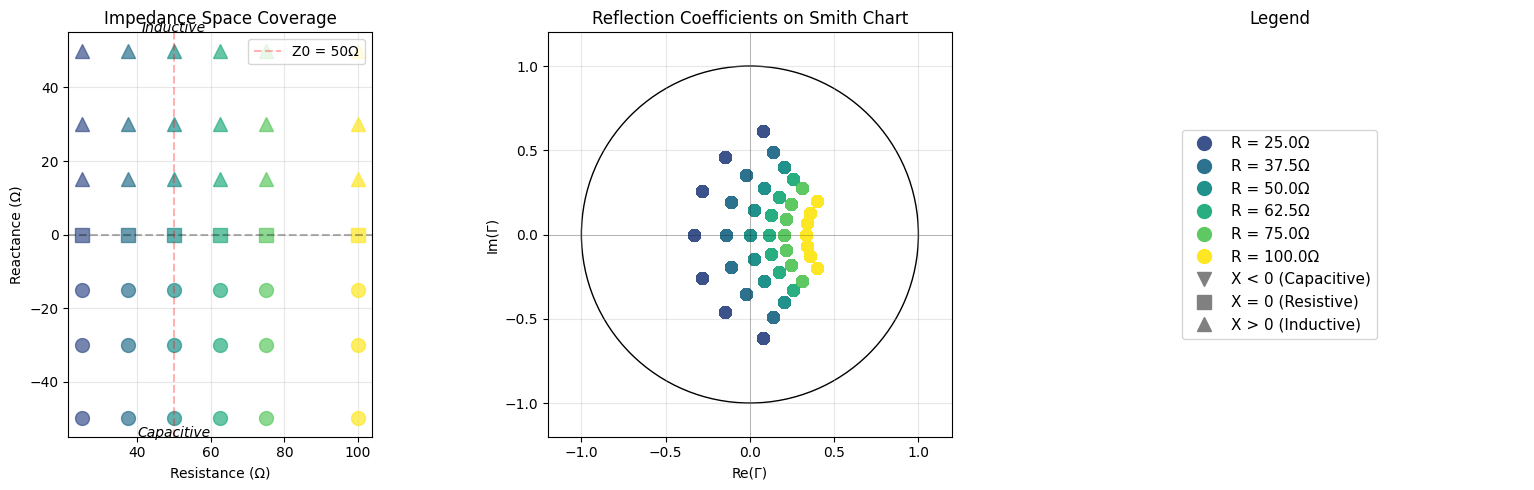


Impedance sweep parameters:
Resistances: [ 25.   37.5  50.   62.5  75.  100. ]
Reactances: [-50 -30 -15   0  15  30  50]


In [21]:
# Create a visualization of the impedance space we're exploring
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Impedance on complex plane
ax = axes[0]
for R in resistances:
    for X in reactances:
        Z = R + 1j * X
        color = plt.cm.viridis(R / resistances.max())
        marker = 'o' if X < 0 else ('^' if X > 0 else 's')
        ax.plot(Z.real, Z.imag, marker, color=color, markersize=10, alpha=0.7)

ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=50, color='r', linestyle='--', alpha=0.3, label='Z0 = 50Ω')
ax.set_xlabel('Resistance (Ω)')
ax.set_ylabel('Reactance (Ω)')
ax.set_title('Impedance Space Coverage')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Add annotations
ax.text(50, -55, 'Capacitive', ha='center', fontsize=10, style='italic')
ax.text(50, 55, 'Inductive', ha='center', fontsize=10, style='italic')

# Plot 2: Smith Chart with all impedances
ax = axes[1]
for net in networks:
    R = net.params['R']
    color = plt.cm.viridis(R / resistances.max())
    ax.plot(net.s[:, 0, 0].real, net.s[:, 0, 0].imag, 'o', 
            color=color, markersize=8, alpha=0.7, label=f'R={R}Ω' if net.params['X'] == 0 else '')

# Draw Smith chart circles
from matplotlib.patches import Circle
ax.add_patch(Circle((0, 0), 1, fill=False, edgecolor='black', linewidth=1))
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
ax.set_xlabel('Re(Γ)')
ax.set_ylabel('Im(Γ)')
ax.set_title('Reflection Coefficients on Smith Chart')
ax.grid(True, alpha=0.3)

# Plot 3: Color legend
ax = axes[2]
ax.axis('off')
for i, R in enumerate(resistances):
    color = plt.cm.viridis(R / resistances.max())
    ax.plot([], [], 'o', color=color, markersize=10, label=f'R = {R}Ω')
ax.plot([], [], 'v', color='gray', markersize=10, label='X < 0 (Capacitive)')
ax.plot([], [], 's', color='gray', markersize=10, label='X = 0 (Resistive)')
ax.plot([], [], '^', color='gray', markersize=10, label='X > 0 (Inductive)')
ax.legend(loc='center', fontsize=11)
ax.set_title('Legend')

plt.tight_layout()
plt.show()

print("\nImpedance sweep parameters:")
print(f"Resistances: {resistances}")
print(f"Reactances: {reactances}")

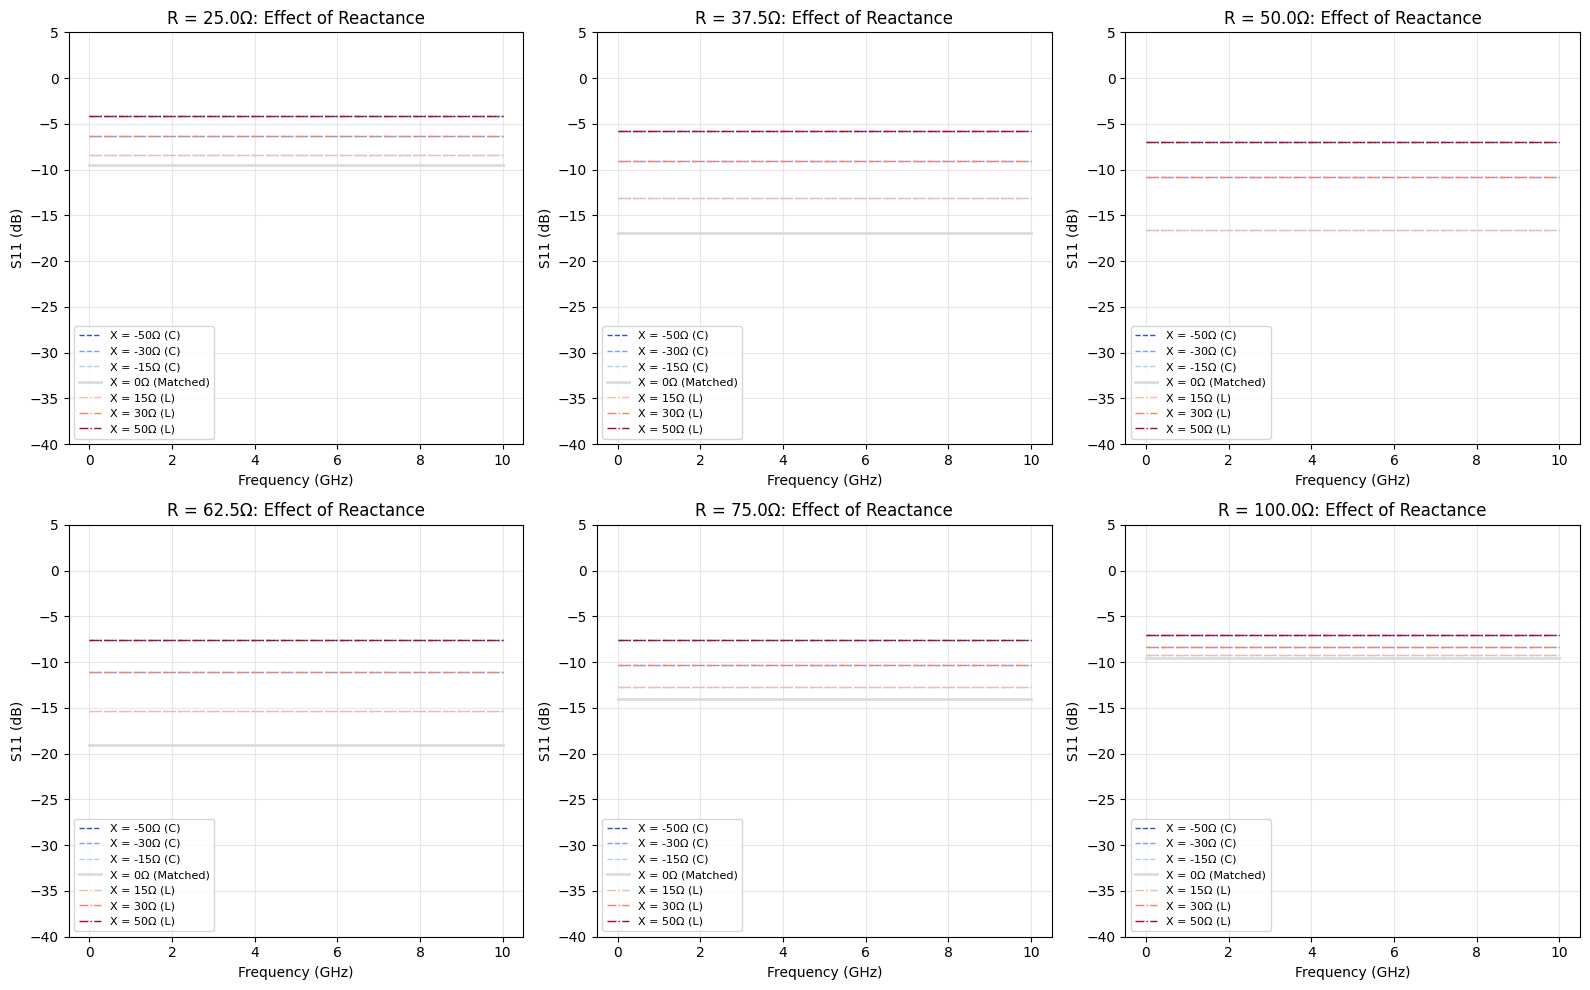

In [22]:
# Show effect of reactance for different resistance values
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, R in enumerate(resistances):
    ax = axes[idx]
    
    for net in networks:
        if net.params['R'] == R:
            X = net.params['X']
            s11_db = 20 * np.log10(np.abs(net.s[:, 0, 0]) + 1e-10)
            
            if X < 0:
                linestyle = '--'
                label = f'X = {X}Ω (C)'
            elif X > 0:
                linestyle = '-.'
                label = f'X = {X}Ω (L)'
            else:
                linestyle = '-'
                label = f'X = {X}Ω (Matched)'
                
            color = plt.cm.coolwarm((X + 50) / 100)  # Normalize to 0-1
            ax.plot(net.frequency.f / 1e9, s11_db, linestyle=linestyle, 
                   color=color, label=label, linewidth=2 if X == 0 else 1)
    
    ax.set_xlabel('Frequency (GHz)')
    ax.set_ylabel('S11 (dB)')
    ax.set_title(f'R = {R}Ω: Effect of Reactance')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')
    ax.set_ylim([-40, 5])

plt.tight_layout()
plt.show()

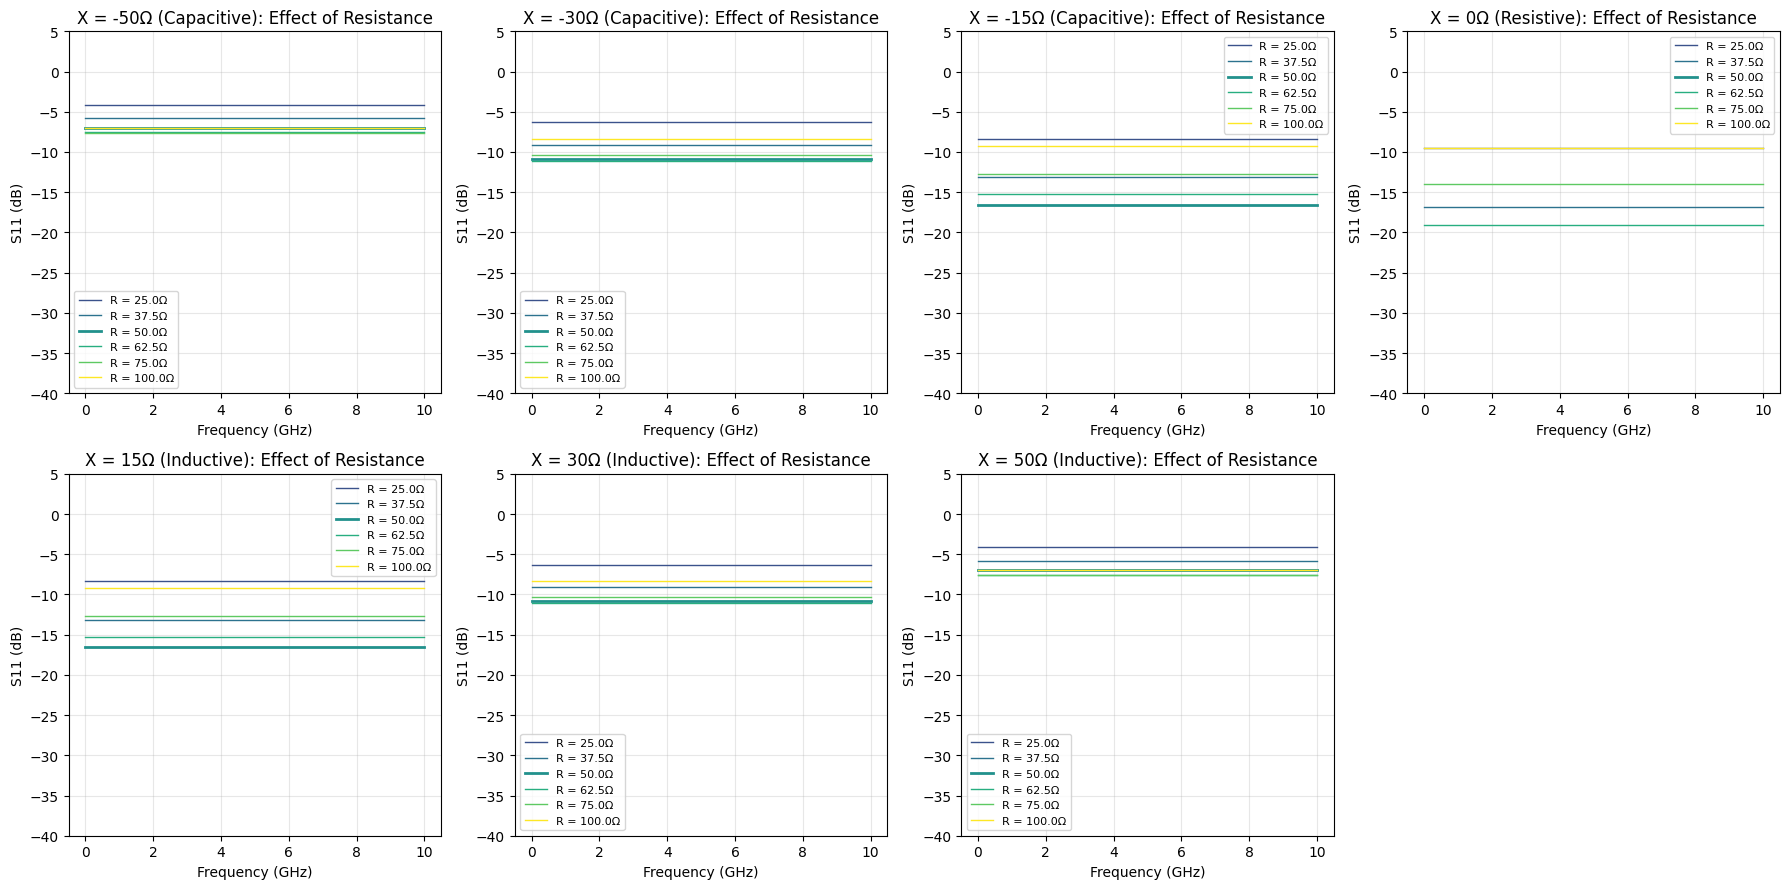

In [23]:
# Show effect of resistance for different reactance values
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

for idx, X in enumerate(reactances):
    ax = axes[idx]
    
    for net in networks:
        if net.params['X'] == X:
            R = net.params['R']
            s11_db = 20 * np.log10(np.abs(net.s[:, 0, 0]) + 1e-10)
            
            color = plt.cm.viridis(R / resistances.max())
            linewidth = 2 if R == 50 else 1
            ax.plot(net.frequency.f / 1e9, s11_db, 
                   color=color, label=f'R = {R}Ω', linewidth=linewidth)
    
    ax.set_xlabel('Frequency (GHz)')
    ax.set_ylabel('S11 (dB)')
    
    if X < 0:
        title = f'X = {X}Ω (Capacitive): Effect of Resistance'
    elif X > 0:
        title = f'X = {X}Ω (Inductive): Effect of Resistance'
    else:
        title = f'X = {X}Ω (Resistive): Effect of Resistance'
    
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')
    ax.set_ylim([-40, 5])

# Hide the extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

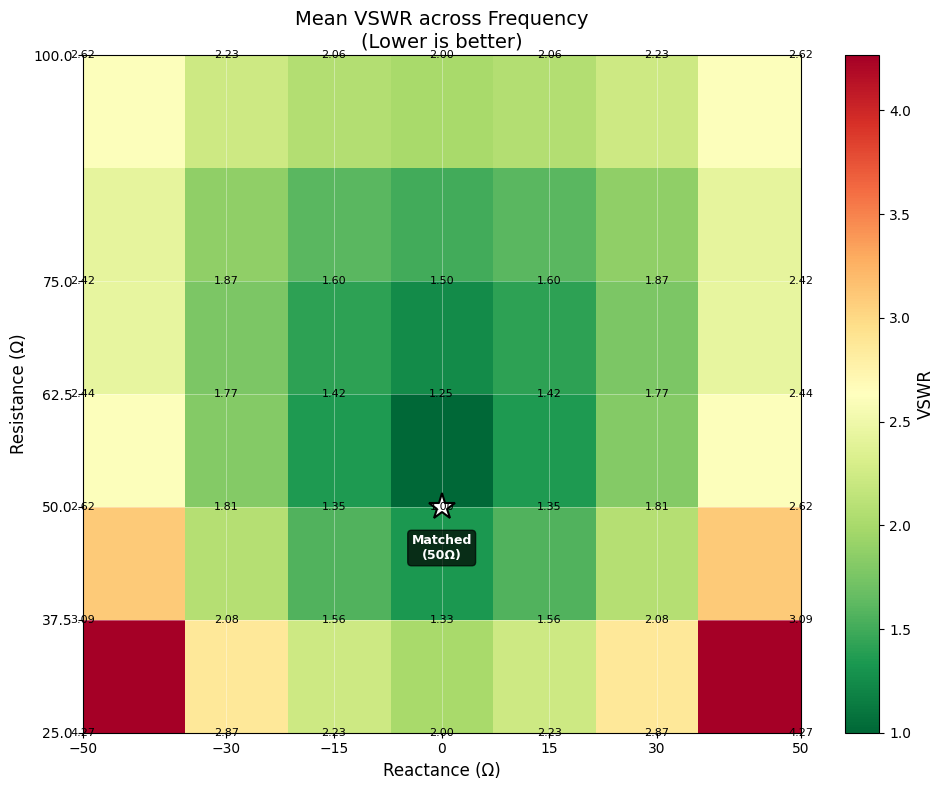

In [24]:
# Create heatmap showing VSWR for all R,X combinations
vswr_matrix = np.zeros((len(resistances), len(reactances)))

for i, R in enumerate(resistances):
    for j, X in enumerate(reactances):
        # Find the network with these parameters
        for net in networks:
            if net.params['R'] == R and net.params['X'] == X:
                s11_mag = np.abs(net.s[:, 0, 0])
                vswr = (1 + s11_mag) / (1 - s11_mag + 1e-10)
                # Take mean VSWR across frequency
                vswr_matrix[i, j] = np.mean(vswr)
                break

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(vswr_matrix, aspect='auto', origin='lower', cmap='RdYlGn_r',
               extent=[reactances.min(), reactances.max(), resistances.min(), resistances.max()])

ax.set_xlabel('Reactance (Ω)', fontsize=12)
ax.set_ylabel('Resistance (Ω)', fontsize=12)
ax.set_title('Mean VSWR across Frequency\n(Lower is better)', fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('VSWR', fontsize=12)

# Add grid
ax.set_xticks(reactances)
ax.set_yticks(resistances)
ax.grid(True, color='white', linewidth=0.5, alpha=0.5)

# Add text annotations
for i, R in enumerate(resistances):
    for j, X in enumerate(reactances):
        text = ax.text(X, R, f'{vswr_matrix[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=8)

# Highlight the matched load (R=50, X=0)
ax.plot(0, 50, 'w*', markersize=20, markeredgecolor='black', markeredgewidth=1.5)
ax.text(0, 50-3, 'Matched\n(50Ω)', ha='center', va='top', fontsize=9, 
        fontweight='bold', color='white',
        bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()

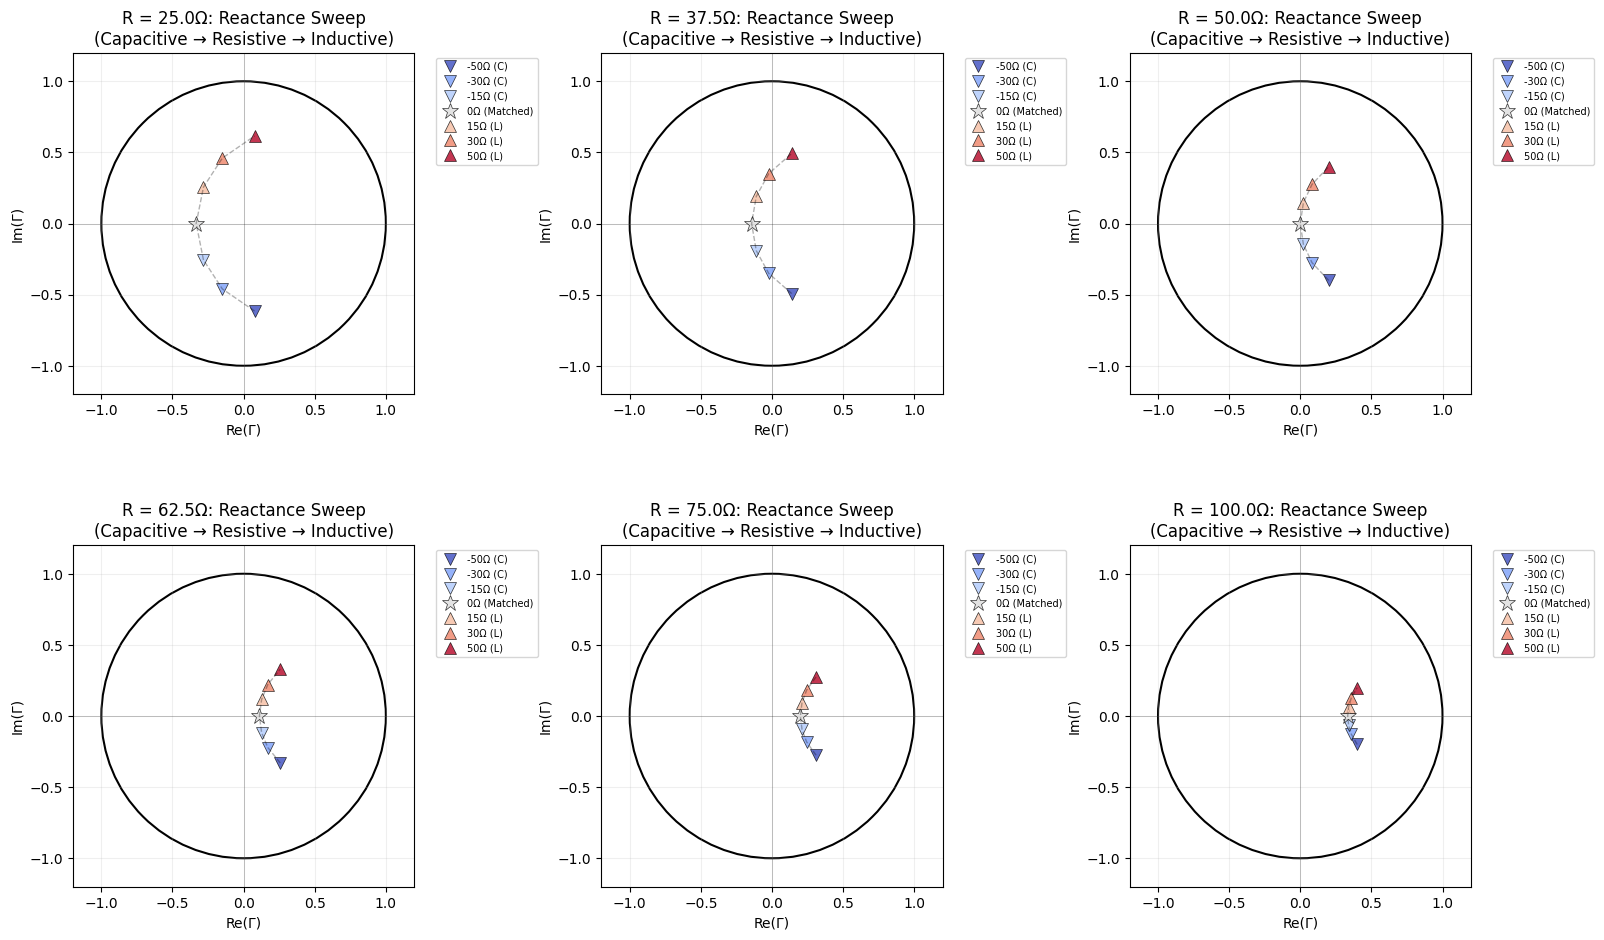

In [25]:
# Create Smith chart showing progression from capacitive to inductive
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, R in enumerate(resistances):
    ax = axes[idx]
    
    # Draw Smith chart boundary
    from matplotlib.patches import Circle
    ax.add_patch(Circle((0, 0), 1, fill=False, edgecolor='black', linewidth=1.5))
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Plot trajectory through reactance
    s11_trajectory = []
    for X in sorted(reactances):
        for net in networks:
            if net.params['R'] == R and net.params['X'] == X:
                s11 = net.s[0, 0, 0]  # Just first frequency point
                s11_trajectory.append((X, s11))
                
                # Color based on reactance
                color = plt.cm.coolwarm((X + 50) / 100)
                
                if X < 0:
                    marker = 'v'
                    label = f'{X}Ω (C)'
                elif X > 0:
                    marker = '^'
                    label = f'{X}Ω (L)'
                else:
                    marker = '*'
                    label = f'{X}Ω (Matched)'
                
                ax.plot(s11.real, s11.imag, marker, color=color, 
                       markersize=12 if X == 0 else 8, 
                       alpha=0.8, label=label,
                       markeredgecolor='black', markeredgewidth=0.5)
                break
    
    # Draw trajectory line
    s11_trajectory.sort(key=lambda x: x[0])  # Sort by X
    trajectory_real = [s[1].real for s in s11_trajectory]
    trajectory_imag = [s[1].imag for s in s11_trajectory]
    ax.plot(trajectory_real, trajectory_imag, 'k--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Re(Γ)')
    ax.set_ylabel('Im(Γ)')
    ax.set_title(f'R = {R}Ω: Reactance Sweep\n(Capacitive → Resistive → Inductive)')
    ax.legend(fontsize=7, loc='upper left', bbox_to_anchor=(1.05, 1))
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

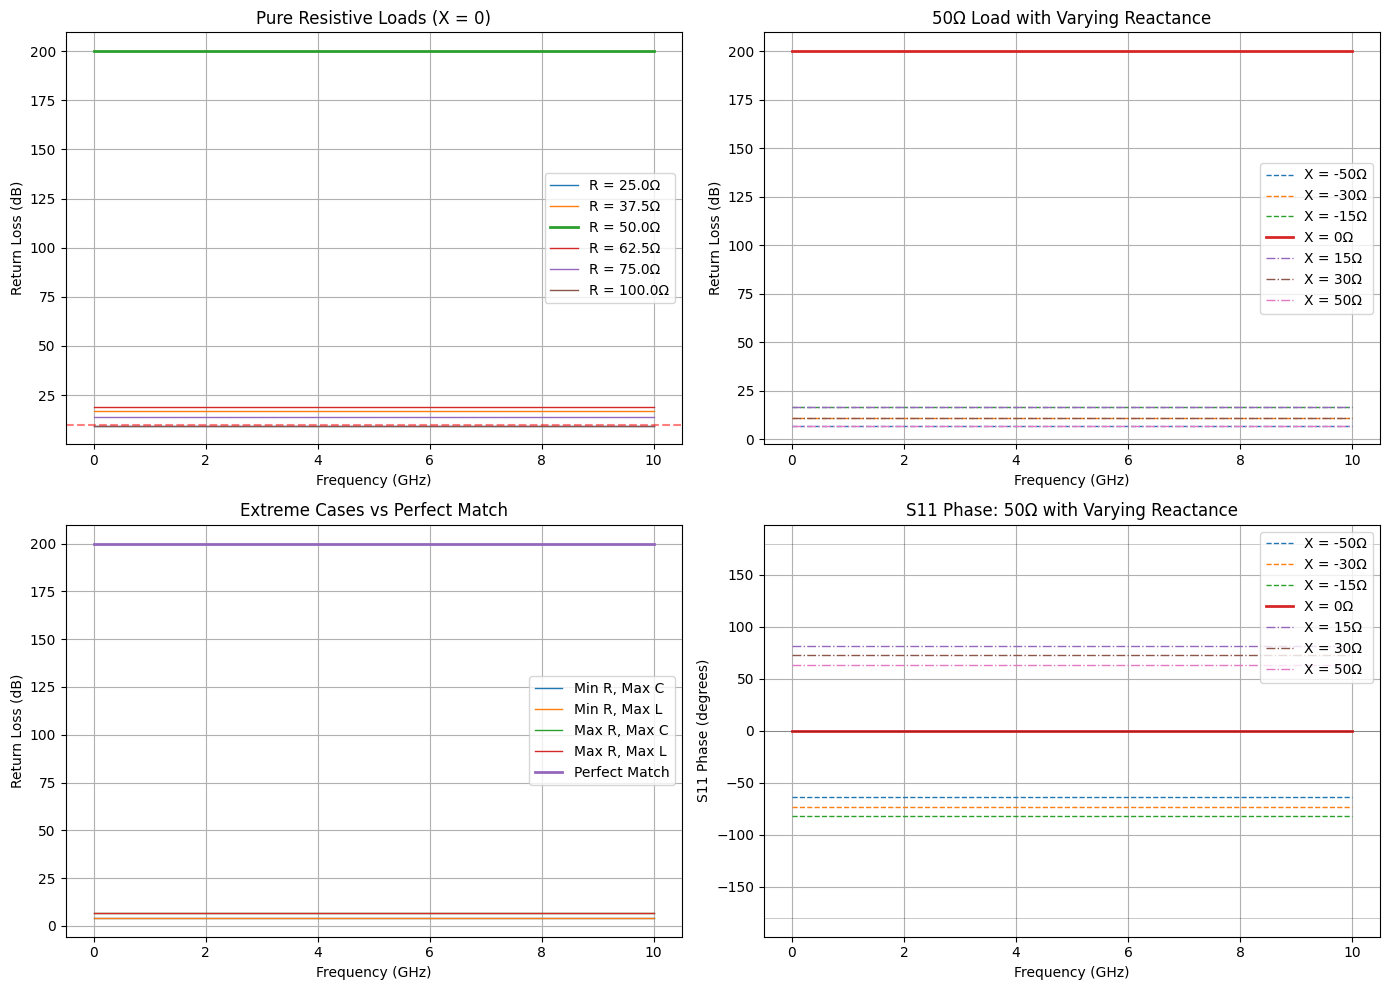

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Perfect match vs pure resistive mismatches
ax = axes[0, 0]
for net in networks:
    if net.params['X'] == 0:  # Only resistive loads
        R = net.params['R']
        s11_db = 20 * np.log10(np.abs(net.s[:, 0, 0]) + 1e-10)
        return_loss = -s11_db
        
        linewidth = 2 if R == 50 else 1
        ax.plot(net.frequency.f / 1e9, return_loss, 
               label=f'R = {R}Ω', linewidth=linewidth)

ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Return Loss (dB)')
ax.set_title('Pure Resistive Loads (X = 0)')
ax.legend()
ax.grid(True)
ax.axhline(y=10, color='r', linestyle='--', alpha=0.5, label='10dB RL')

# Plot 2: 50Ω with varying reactance
ax = axes[0, 1]
for net in networks:
    if net.params['R'] == 50:  # 50Ω resistance
        X = net.params['X']
        s11_db = 20 * np.log10(np.abs(net.s[:, 0, 0]) + 1e-10)
        return_loss = -s11_db
        
        if X < 0:
            linestyle = '--'
        elif X > 0:
            linestyle = '-.'
        else:
            linestyle = '-'
        
        linewidth = 2 if X == 0 else 1
        ax.plot(net.frequency.f / 1e9, return_loss, linestyle=linestyle,
               label=f'X = {X}Ω', linewidth=linewidth)

ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Return Loss (dB)')
ax.set_title('50Ω Load with Varying Reactance')
ax.legend()
ax.grid(True)

# Plot 3: Worst cases - maximum mismatch
ax = axes[1, 0]
worst_cases = [
    (25, -50, 'Min R, Max C'),
    (25, 50, 'Min R, Max L'),
    (100, -50, 'Max R, Max C'),
    (100, 50, 'Max R, Max L'),
    (50, 0, 'Perfect Match')
]

for R, X, label in worst_cases:
    for net in networks:
        if net.params['R'] == R and net.params['X'] == X:
            s11_db = 20 * np.log10(np.abs(net.s[:, 0, 0]) + 1e-10)
            return_loss = -s11_db
            
            linewidth = 2 if (R == 50 and X == 0) else 1
            ax.plot(net.frequency.f / 1e9, return_loss, 
                   label=label, linewidth=linewidth)
            break

ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Return Loss (dB)')
ax.set_title('Extreme Cases vs Perfect Match')
ax.legend()
ax.grid(True)

# Plot 4: Phase of S11 for different reactances (R=50)
ax = axes[1, 1]
for net in networks:
    if net.params['R'] == 50:
        X = net.params['X']
        phase = np.angle(net.s[:, 0, 0], deg=True)
        
        if X < 0:
            linestyle = '--'
        elif X > 0:
            linestyle = '-.'
        else:
            linestyle = '-'
        
        linewidth = 2 if X == 0 else 1
        ax.plot(net.frequency.f / 1e9, phase, linestyle=linestyle,
               label=f'X = {X}Ω', linewidth=linewidth)

ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('S11 Phase (degrees)')
ax.set_title('S11 Phase: 50Ω with Varying Reactance')
ax.legend()
ax.grid(True)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
ax.axhline(y=180, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
ax.axhline(y=-180, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
print("=" * 80)
print("NETWORK SET SUMMARY")
print("=" * 80)
print(f"\nTotal networks in set: {len(networks)}")
print(f"Frequency range: {freq.f[0]/1e9:.2f} - {freq.f[-1]/1e9:.2f} GHz")
print(f"Number of frequency points: {len(freq)}")
print(f"\nParameter ranges:")
print(f"  Resistance: {resistances.min():.1f} - {resistances.max():.1f} Ω")
print(f"  Reactance: {reactances.min():.1f} - {reactances.max():.1f} Ω")

print("\n" + "-" * 80)
print("Best and Worst Matches")
print("-" * 80)

best_match = None
worst_match = None
best_vswr = float('inf')
worst_vswr = 0

for net in networks:
    s11_mag = np.abs(net.s[:, 0, 0])
    vswr = (1 + s11_mag) / (1 - s11_mag + 1e-10)
    mean_vswr = np.mean(vswr)
    
    if mean_vswr < best_vswr:
        best_vswr = mean_vswr
        best_match = net
    
    if mean_vswr > worst_vswr:
        worst_vswr = mean_vswr
        worst_match = net

print(f"\nBest Match:")
print(f"  Network: {best_match.name}")
print(f"  R = {best_match.params['R']:.1f} Ω, X = {best_match.params['X']:.1f} Ω")
print(f"  Mean VSWR: {best_vswr:.3f}:1")
print(f"  Mean Return Loss: {-np.mean(20*np.log10(np.abs(best_match.s[:,0,0])+1e-10)):.2f} dB")

print(f"\nWorst Match:")
print(f"  Network: {worst_match.name}")
print(f"  R = {worst_match.params['R']:.1f} Ω, X = {worst_match.params['X']:.1f} Ω")
print(f"  Mean VSWR: {worst_vswr:.3f}:1")
print(f"  Mean Return Loss: {-np.mean(20*np.log10(np.abs(worst_match.s[:,0,0])+1e-10)):.2f} dB")

print("\n" + "=" * 80)

NETWORK SET SUMMARY

Total networks in set: 42
Frequency range: 0.00 - 10.00 GHz
Number of frequency points: 101

Parameter ranges:
  Resistance: 25.0 - 100.0 Ω
  Reactance: -50.0 - 50.0 Ω

--------------------------------------------------------------------------------
Best and Worst Matches
--------------------------------------------------------------------------------

Best Match:
  Network: Load_R50.0_X0.0
  R = 50.0 Ω, X = 0.0 Ω
  Mean VSWR: 1.000:1
  Mean Return Loss: 200.00 dB

Worst Match:
  Network: Load_R25.0_X-50.0
  R = 25.0 Ω, X = -50.0 Ω
  Mean VSWR: 4.266:1
  Mean Return Loss: 4.15 dB



# Load pull like network 

In [28]:
@attrs.define
class OnePortNetworkSet:
    """Class to manage and analyze a set of one-port networks (e.g., load-pull data)"""
    network_set: NetworkSet = attrs.field()
    reference_network: Optional[rf.Network] = attrs.field(default=None)
    _analyzers: list = attrs.field(init=False, factory=list)
    
    def __attrs_post_init__(self):
        """Create OnePortAnalyzer instances for each network"""
        print(f"Creating {len(self.network_set)} OnePortAnalyzer instances...")
        
        for net in self.network_set:
            # Validate 1-port
            if net.s.shape[1:] != (1, 1):
                raise ValueError(f"Network {net.name} is not a 1-port network")
            
            # Create analyzer with or without reference
            analyzer = OnePortAnalyzer(
                network=net,
                reference_network=self.reference_network
            )
            self._analyzers.append(analyzer)
        
        print(f"✓ Created {len(self._analyzers)} analyzers")
    
    # ==================== Access Methods ====================
    
    def __len__(self):
        """Number of networks in set"""
        return len(self.network_set)
    
    def __getitem__(self, idx):
        """Get analyzer by index"""
        return self._analyzers[idx]
    
    def __iter__(self):
        """Iterate over analyzers"""
        return iter(self._analyzers)
    
    @property
    def analyzers(self):
        """Get list of all analyzers"""
        return self._analyzers
    
    @property
    def networks(self):
        """Get list of all networks"""
        return list(self.network_set)
    
    # ==================== Parameter Extraction ====================
    
    def get_param(self, param_name):
        """Extract a specific parameter from all networks"""
        return np.array([net.params.get(param_name) for net in self.network_set])
    
    def get_unique_params(self, param_name):
        """Get unique values of a parameter"""
        return np.unique(self.get_param(param_name))
    
    @property
    def param_names(self):
        """Get list of available parameter names"""
        if len(self.network_set) > 0:
            return list(self.network_set[0].params.keys())
        return []
    
    # ==================== Load-Pull Grid Creation ====================
    
    def get_load_pull_grid(self, r_param='R', x_param='X'):
        """
        Get load-pull data organized as a grid
        
        Returns
        -------
        R_vals : array
            Unique resistance values
        X_vals : array
            Unique reactance values
        grid_data : dict
            Dictionary mapping (R, X) to analyzer index
        """
        R_vals = self.get_unique_params(r_param)
        X_vals = self.get_unique_params(x_param)
        
        grid_data = {}
        for idx, net in enumerate(self.network_set):
            R = net.params[r_param]
            X = net.params[x_param]
            grid_data[(R, X)] = idx
        
        return R_vals, X_vals, grid_data
    
    def create_metric_grid(self, metric_func, r_param='R', x_param='X'):
        """
        Create a 2D grid of a metric across R and X
        
        Parameters
        ----------
        metric_func : callable
            Function that takes an analyzer and returns a scalar metric
        r_param : str
            Parameter name for resistance
        x_param : str
            Parameter name for reactance
            
        Returns
        -------
        R_vals : array
            Resistance values
        X_vals : array
            Reactance values
        metric_grid : 2D array
            Grid of metric values
        """
        R_vals, X_vals, grid_data = self.get_load_pull_grid(r_param, x_param)
        
        metric_grid = np.zeros((len(R_vals), len(X_vals)))
        
        for i, R in enumerate(R_vals):
            for j, X in enumerate(X_vals):
                idx = grid_data.get((R, X))
                if idx is not None:
                    metric_grid[i, j] = metric_func(self._analyzers[idx])
                else:
                    metric_grid[i, j] = np.nan
        
        return R_vals, X_vals, metric_grid
    
    # ==================== Summary Methods ====================
    
    def summary(self):
        """Print summary of network set"""
        print("=" * 80)
        print("ONE-PORT NETWORK SET SUMMARY")
        print("=" * 80)
        print(f"\nTotal networks: {len(self)}")
        
        if len(self) > 0:
            print(f"Frequency range: {self._analyzers[0].min_freq_ghz:.4f} - {self._analyzers[0].max_freq_ghz:.4f} GHz")
            print(f"Number of frequency points: {self._analyzers[0].num_points}")
            print(f"Z0: {self._analyzers[0].z0:.2f} Ω")
        
        print(f"\nAvailable parameters: {self.param_names}")
        for param in self.param_names:
            unique_vals = self.get_unique_params(param)
            print(f"  {param}: {len(unique_vals)} unique values, range [{unique_vals.min():.2f}, {unique_vals.max():.2f}]")
        
        print(f"\nHas noise reference: {self.reference_network is not None}")
        
        # Find best and worst matches
        vswrs = [analyzer.vswr_mean for analyzer in self._analyzers]
        best_idx = np.argmin(vswrs)
        worst_idx = np.argmax(vswrs)
        
        print("\n" + "-" * 80)
        print("Best Match:")
        print(f"  Network: {self.networks[best_idx].name}")
        print(f"  Parameters: {self.networks[best_idx].params}")
        print(f"  Mean VSWR: {vswrs[best_idx]:.3f}:1")
        print(f"  Mean Return Loss: {self._analyzers[best_idx].mean_return_loss_db:.2f} dB")
        
        print("\nWorst Match:")
        print(f"  Network: {self.networks[worst_idx].name}")
        print(f"  Parameters: {self.networks[worst_idx].params}")
        print(f"  Mean VSWR: {vswrs[worst_idx]:.3f}:1")
        print(f"  Mean Return Loss: {self._analyzers[worst_idx].mean_return_loss_db:.2f} dB")
        
        print("=" * 80)
    
    # ==================== Load-Pull Visualization ====================
    
    def plot_smith_loadpull(self, ax=None, freq_idx=0, r_param='R', x_param='X', 
                           colormap='viridis', metric='vswr'):
        """
        Plot load-pull data on Smith chart with color coding
        
        Parameters
        ----------
        ax : matplotlib axis
            Axis to plot on
        freq_idx : int
            Frequency index to plot
        metric : str
            Metric to color-code: 'vswr', 'return_loss', 's11_db'
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        
        # Draw Smith chart boundary
        from matplotlib.patches import Circle
        ax.add_patch(Circle((0, 0), 1, fill=False, edgecolor='black', linewidth=1.5))
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        ax.set_aspect('equal')
        ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
        ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
        
        # Get metric values
        if metric == 'vswr':
            metric_values = np.array([analyzer.vswr[freq_idx] for analyzer in self._analyzers])
            cbar_label = 'VSWR'
        elif metric == 'return_loss':
            metric_values = np.array([analyzer.return_loss_db[freq_idx] for analyzer in self._analyzers])
            cbar_label = 'Return Loss (dB)'
        elif metric == 's11_db':
            metric_values = np.array([analyzer.s11_db[freq_idx] for analyzer in self._analyzers])
            cbar_label = 'S11 (dB)'
        else:
            raise ValueError(f"Unknown metric: {metric}")
        
        # Plot points
        scatter = ax.scatter(
            [analyzer.s11[freq_idx].real for analyzer in self._analyzers],
            [analyzer.s11[freq_idx].imag for analyzer in self._analyzers],
            c=metric_values,
            cmap=colormap,
            s=100,
            alpha=0.7,
            edgecolors='black',
            linewidths=0.5
        )
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label(cbar_label, fontsize=11)
        
        # Mark matched load if it exists
        for analyzer in self._analyzers:
            if abs(analyzer.network.params.get('R', 0) - 50) < 0.1 and abs(analyzer.network.params.get('X', 0)) < 0.1:
                s11 = analyzer.s11[freq_idx]
                ax.plot(s11.real, s11.imag, 'w*', markersize=20, 
                       markeredgecolor='black', markeredgewidth=2)
        
        ax.set_xlabel('Re(Γ)')
        ax.set_ylabel('Im(Γ)')
        freq_ghz = self._analyzers[0].freq_ghz[freq_idx]
        ax.set_title(f'Load-Pull Smith Chart\n{metric.upper()} @ {freq_ghz:.2f} GHz')
        ax.grid(True, alpha=0.2)
        
        return ax
    
    def plot_loadpull_contours(self, ax=None, freq_idx=0, r_param='R', x_param='X',
                              metric='vswr', levels=None):
        """
        Plot load-pull contours on Smith chart
        
        Parameters
        ----------
        metric : str
            Metric to plot contours: 'vswr', 'return_loss', 's11_db'
        levels : array-like
            Contour levels to plot
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        
        # Draw Smith chart boundary
        from matplotlib.patches import Circle
        ax.add_patch(Circle((0, 0), 1, fill=False, edgecolor='black', linewidth=2))
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        ax.set_aspect('equal')
        
        # Get data
        real_parts = np.array([analyzer.s11[freq_idx].real for analyzer in self._analyzers])
        imag_parts = np.array([analyzer.s11[freq_idx].imag for analyzer in self._analyzers])
        
        if metric == 'vswr':
            metric_values = np.array([analyzer.vswr[freq_idx] for analyzer in self._analyzers])
            cbar_label = 'VSWR'
            if levels is None:
                levels = [1.2, 1.5, 2.0, 3.0, 5.0]
        elif metric == 'return_loss':
            metric_values = np.array([analyzer.return_loss_db[freq_idx] for analyzer in self._analyzers])
            cbar_label = 'Return Loss (dB)'
            if levels is None:
                levels = [10, 15, 20, 25, 30]
        elif metric == 's11_db':
            metric_values = np.array([analyzer.s11_db[freq_idx] for analyzer in self._analyzers])
            cbar_label = 'S11 (dB)'
            if levels is None:
                levels = [-30, -25, -20, -15, -10]
        
        # Create interpolated grid for contours
        from scipy.interpolate import griddata
        
        # Create fine grid
        grid_real = np.linspace(-1, 1, 200)
        grid_imag = np.linspace(-1, 1, 200)
        grid_r, grid_i = np.meshgrid(grid_real, grid_imag)
        
        # Interpolate
        grid_metric = griddata(
            (real_parts, imag_parts),
            metric_values,
            (grid_r, grid_i),
            method='cubic'
        )
        
        # Mask outside Smith chart
        mask = grid_r**2 + grid_i**2 > 1
        grid_metric[mask] = np.nan
        
        # Plot contours
        contour = ax.contour(grid_r, grid_i, grid_metric, levels=levels, 
                            colors='black', linewidths=1.5, alpha=0.7)
        ax.clabel(contour, inline=True, fontsize=9, fmt='%.1f')
        
        # Filled contours
        contourf = ax.contourf(grid_r, grid_i, grid_metric, levels=20, 
                              cmap='RdYlGn_r' if metric == 'vswr' else 'RdYlGn', 
                              alpha=0.3)
        
        # Plot measurement points
        ax.scatter(real_parts, imag_parts, c='blue', s=30, alpha=0.6, 
                  edgecolors='black', linewidths=0.5, label='Load Points')
        
        # Mark matched load
        for analyzer in self._analyzers:
            if abs(analyzer.network.params.get('R', 0) - 50) < 0.1 and abs(analyzer.network.params.get('X', 0)) < 0.1:
                s11 = analyzer.s11[freq_idx]
                ax.plot(s11.real, s11.imag, 'w*', markersize=20, 
                       markeredgecolor='black', markeredgewidth=2, label='50Ω Match')
        
        ax.set_xlabel('Re(Γ)')
        ax.set_ylabel('Im(Γ)')
        freq_ghz = self._analyzers[0].freq_ghz[freq_idx]
        ax.set_title(f'Load-Pull Contours: {metric.upper()}\n@ {freq_ghz:.2f} GHz')
        ax.legend(loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.2)
        
        # Colorbar
        cbar = plt.colorbar(contourf, ax=ax)
        cbar.set_label(cbar_label, fontsize=11)
        
        return ax
    
    def plot_impedance_grid(self, ax=None, r_param='R', x_param='X', metric='vswr'):
        """Plot heatmap of metric vs R and X"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        
        # Create metric grid
        if metric == 'vswr':
            R_vals, X_vals, metric_grid = self.create_metric_grid(lambda a: a.vswr_mean, r_param, x_param)
            cbar_label = 'Mean VSWR'
            cmap = 'RdYlGn_r'
        elif metric == 'return_loss':
            R_vals, X_vals, metric_grid = self.create_metric_grid(lambda a: a.mean_return_loss_db, r_param, x_param)
            cbar_label = 'Mean Return Loss (dB)'
            cmap = 'RdYlGn'
        elif metric == 's11_db':
            R_vals, X_vals, metric_grid = self.create_metric_grid(lambda a: a.s11_mean_db, r_param, x_param)
            cbar_label = 'Mean S11 (dB)'
            cmap = 'RdYlGn'
        
        im = ax.imshow(metric_grid, aspect='auto', origin='lower', cmap=cmap,
                      extent=[X_vals.min(), X_vals.max(), R_vals.min(), R_vals.max()])
        
        ax.set_xlabel('Reactance (Ω)', fontsize=12)
        ax.set_ylabel('Resistance (Ω)', fontsize=12)
        ax.set_title(f'Load-Pull Heatmap: {metric.upper()}', fontsize=14)
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label(cbar_label, fontsize=12)
        
        # Grid
        ax.set_xticks(X_vals)
        ax.set_yticks(R_vals)
        ax.grid(True, color='white', linewidth=0.5, alpha=0.5)
        
        # Mark matched point
        if 50 in R_vals and 0 in X_vals:
            ax.plot(0, 50, 'w*', markersize=20, markeredgecolor='black', markeredgewidth=1.5)
        
        return ax
    
    def plot_loadpull_summary(self, freq_idx=0, figsize=(18, 12)):
        """Create comprehensive load-pull visualization"""
        fig = plt.figure(figsize=figsize)
        
        # Row 1: Smith charts
        ax1 = plt.subplot(2, 3, 1)
        self.plot_smith_loadpull(ax=ax1, freq_idx=freq_idx, metric='vswr')
        
        ax2 = plt.subplot(2, 3, 2)
        self.plot_loadpull_contours(ax=ax2, freq_idx=freq_idx, metric='vswr')
        
        ax3 = plt.subplot(2, 3, 3)
        self.plot_loadpull_contours(ax=ax3, freq_idx=freq_idx, metric='return_loss')
        
        # Row 2: Heatmaps
        ax4 = plt.subplot(2, 3, 4)
        self.plot_impedance_grid(ax=ax4, metric='vswr')
        
        ax5 = plt.subplot(2, 3, 5)
        self.plot_impedance_grid(ax=ax5, metric='return_loss')
        
        ax6 = plt.subplot(2, 3, 6)
        # Plot S11 vs frequency for key loads
        for analyzer in self._analyzers:
            R = analyzer.network.params.get('R', 0)
            X = analyzer.network.params.get('X', 0)
            
            # Plot only specific cases
            if X == 0:  # Resistive only
                if R == 50:
                    label = f'R={R}Ω (Matched)'
                    linewidth = 2
                    alpha = 1.0
                elif R in [25, 75, 100]:
                    label = f'R={R}Ω'
                    linewidth = 1
                    alpha = 0.7
                else:
                    continue
                
                ax6.plot(analyzer.freq_ghz, analyzer.s11_db, 
                        label=label, linewidth=linewidth, alpha=alpha)
        
        ax6.set_xlabel('Frequency (GHz)')
        ax6.set_ylabel('S11 (dB)')
        ax6.set_title('S11 vs Frequency (Resistive Loads)')
        ax6.legend()
        ax6.grid(True)
        
        plt.tight_layout()
        return fig

print("OnePortNetworkSet class loaded successfully!")

OnePortNetworkSet class loaded successfully!


In [29]:
@attrs.define
class LoadTuner:
    """Simulate a load tuner for load-pull measurements"""
    frequency: rf.Frequency = attrs.field()
    z0: float = attrs.field(default=50.0)
    
    def create_load(self, z_load):
        """
        Create a load network with specified impedance
        
        Parameters
        ----------
        z_load : complex or tuple
            Load impedance (complex number or (R, X) tuple)
            
        Returns
        -------
        load : rf.Network
            One-port load network
        """
        if isinstance(z_load, tuple):
            z_load = z_load[0] + 1j * z_load[1]
        
        # Calculate S11 = (Z_L - Z0) / (Z_L + Z0)
        s11 = (z_load - self.z0) / (z_load + self.z0)
        
        load = rf.Network(
            frequency=self.frequency,
            s=s11 * np.ones((len(self.frequency), 1, 1)),
            z0=self.z0,
            name=f'Load_Z{z_load:.1f}'
        )
        
        load.params = {
            'R': z_load.real,
            'X': z_load.imag,
            'Z_mag': np.abs(z_load),
            'Z_phase': np.angle(z_load, deg=True)
        }
        
        return load
    
    def create_gamma_load(self, gamma):
        """
        Create load from reflection coefficient
        
        Parameters
        ----------
        gamma : complex
            Reflection coefficient
            
        Returns
        -------
        load : rf.Network
            One-port load network
        """
        # Z_L = Z0 * (1 + gamma) / (1 - gamma)
        z_load = self.z0 * (1 + gamma) / (1 - gamma)
        return self.create_load(z_load)
    
    def sweep_impedance_grid(self, r_values, x_values):
        """
        Create NetworkSet sweeping R and X values
        
        Parameters
        ----------
        r_values : array-like
            Resistance values
        x_values : array-like
            Reactance values
            
        Returns
        -------
        network_set : NetworkSet
            Set of load networks
        """
        networks = []
        
        for R in r_values:
            for X in x_values:
                load = self.create_load((R, X))
                networks.append(load)
        
        return NetworkSet(networks)
    
    def sweep_gamma_circle(self, gamma_mag, num_points=36):
        """
        Create NetworkSet sweeping constant |Γ| circle
        
        Parameters
        ----------
        gamma_mag : float
            Magnitude of reflection coefficient
        num_points : int
            Number of points around circle
            
        Returns
        -------
        network_set : NetworkSet
            Set of load networks
        """
        networks = []
        
        angles = np.linspace(0, 2*np.pi, num_points, endpoint=False)
        
        for angle in angles:
            gamma = gamma_mag * np.exp(1j * angle)
            load = self.create_gamma_load(gamma)
            load.params['gamma_mag'] = gamma_mag
            load.params['gamma_angle'] = np.rad2deg(angle)
            networks.append(load)
        
        return NetworkSet(networks)
    
    def sweep_vswr_circle(self, vswr, num_points=36):
        """
        Create NetworkSet sweeping constant VSWR circle
        
        Parameters
        ----------
        vswr : float
            VSWR value
        num_points : int
            Number of points around circle
            
        Returns
        -------
        network_set : NetworkSet
            Set of load networks
        """
        # |Γ| = (VSWR - 1) / (VSWR + 1)
        gamma_mag = (vswr - 1) / (vswr + 1)
        return self.sweep_gamma_circle(gamma_mag, num_points)


@attrs.define  
class SourceTuner:
    """Simulate a source tuner for source-pull measurements"""
    frequency: rf.Frequency = attrs.field()
    z0: float = attrs.field(default=50.0)
    
    def create_source(self, z_source):
        """
        Create a source network with specified impedance
        
        Parameters
        ----------
        z_source : complex or tuple
            Source impedance (complex number or (R, X) tuple)
            
        Returns
        -------
        source : rf.Network
            One-port source network
        """
        if isinstance(z_source, tuple):
            z_source = z_source[0] + 1j * z_source[1]
        
        # S11 from source side
        s11 = (z_source - self.z0) / (z_source + self.z0)
        
        source = rf.Network(
            frequency=self.frequency,
            s=s11 * np.ones((len(self.frequency), 1, 1)),
            z0=self.z0,
            name=f'Source_Z{z_source:.1f}'
        )
        
        source.params = {
            'R': z_source.real,
            'X': z_source.imag,
            'Z_mag': np.abs(z_source),
            'Z_phase': np.angle(z_source, deg=True)
        }
        
        return source

print("LoadTuner and SourceTuner classes loaded successfully!")

LoadTuner and SourceTuner classes loaded successfully!


In [30]:
# Define frequency
freq = rf.Frequency(start=0, stop=10, npoints=101, unit='GHz')

# Create load tuner
tuner = LoadTuner(frequency=freq, z0=50)

# Define load-pull grid (more comprehensive)
r_values = np.array([25, 35, 45, 50, 55, 65, 75, 100])
x_values = np.array([-75, -50, -30, -15, 0, 15, 30, 50, 75])

# Create load network set
load_network_set = tuner.sweep_impedance_grid(r_values, x_values)

print(f"Created {len(load_network_set)} load impedances")
print(f"R values: {r_values}")
print(f"X values: {x_values}")

Created 72 load impedances
R values: [ 25  35  45  50  55  65  75 100]
X values: [-75 -50 -30 -15   0  15  30  50  75]


In [31]:
# Create a simple DUT (could be a component, amp, etc.)
# For this example, just use a transmission line as the DUT
dut_media = rf.media.DefinedGammaZ0(frequency=freq, z0=50)
dut = dut_media.line(d=2, unit='cm', name='DUT')

# Create complete measurement system for each load
loadpull_networks = []

for load in load_network_set:
    # Build circuit: Port -> DUT -> Load
    port1 = rf.Circuit.Port(frequency=freq, name='port1', z0=50)
    
    connections = [
        [(port1, 0), (dut, 0)],
        [(dut, 1), (load, 0)]
    ]
    
    circuit = rf.Circuit(connections)
    measurement = circuit.network
    measurement.name = f"LoadPull_{load.name}"
    measurement.params = load.params.copy()
    
    loadpull_networks.append(measurement)

# Create NetworkSet
loadpull_set = NetworkSet(loadpull_networks)

print(f"Created load-pull measurement set with {len(loadpull_set)} points")

Created load-pull measurement set with 72 points


In [32]:
# Create the OnePortNetworkSet
loadpull_analyzer = OnePortNetworkSet(network_set=loadpull_set)

# Print summary
loadpull_analyzer.summary()

Creating 72 OnePortAnalyzer instances...
✓ Created 72 analyzers
ONE-PORT NETWORK SET SUMMARY

Total networks: 72
Frequency range: 0.0000 - 10.0000 GHz
Number of frequency points: 101
Z0: 50.00+0.00j Ω

Available parameters: ['R', 'X', 'Z_mag', 'Z_phase']
  R: 8 unique values, range [25.00, 100.00]
  X: 9 unique values, range [-75.00, 75.00]
  Z_mag: 39 unique values, range [25.00, 125.00]
  Z_phase: 57 unique values, range [-71.57, 71.57]

Has noise reference: False

--------------------------------------------------------------------------------
Best Match:
  Network: LoadPull_Load_Z50.0+0.0j
  Parameters: {'R': 50.0, 'X': 0.0, 'Z_mag': 50.0, 'Z_phase': 0.0}
  Mean VSWR: 1.000:1
  Mean Return Loss: 200.00 dB

Worst Match:
  Network: LoadPull_Load_Z25.0-75.0j
  Parameters: {'R': 25.0, 'X': -75.0, 'Z_mag': 79.05694150420949, 'Z_phase': -71.56505117707799}
  Mean VSWR: 6.854:1
  Mean Return Loss: 2.55 dB


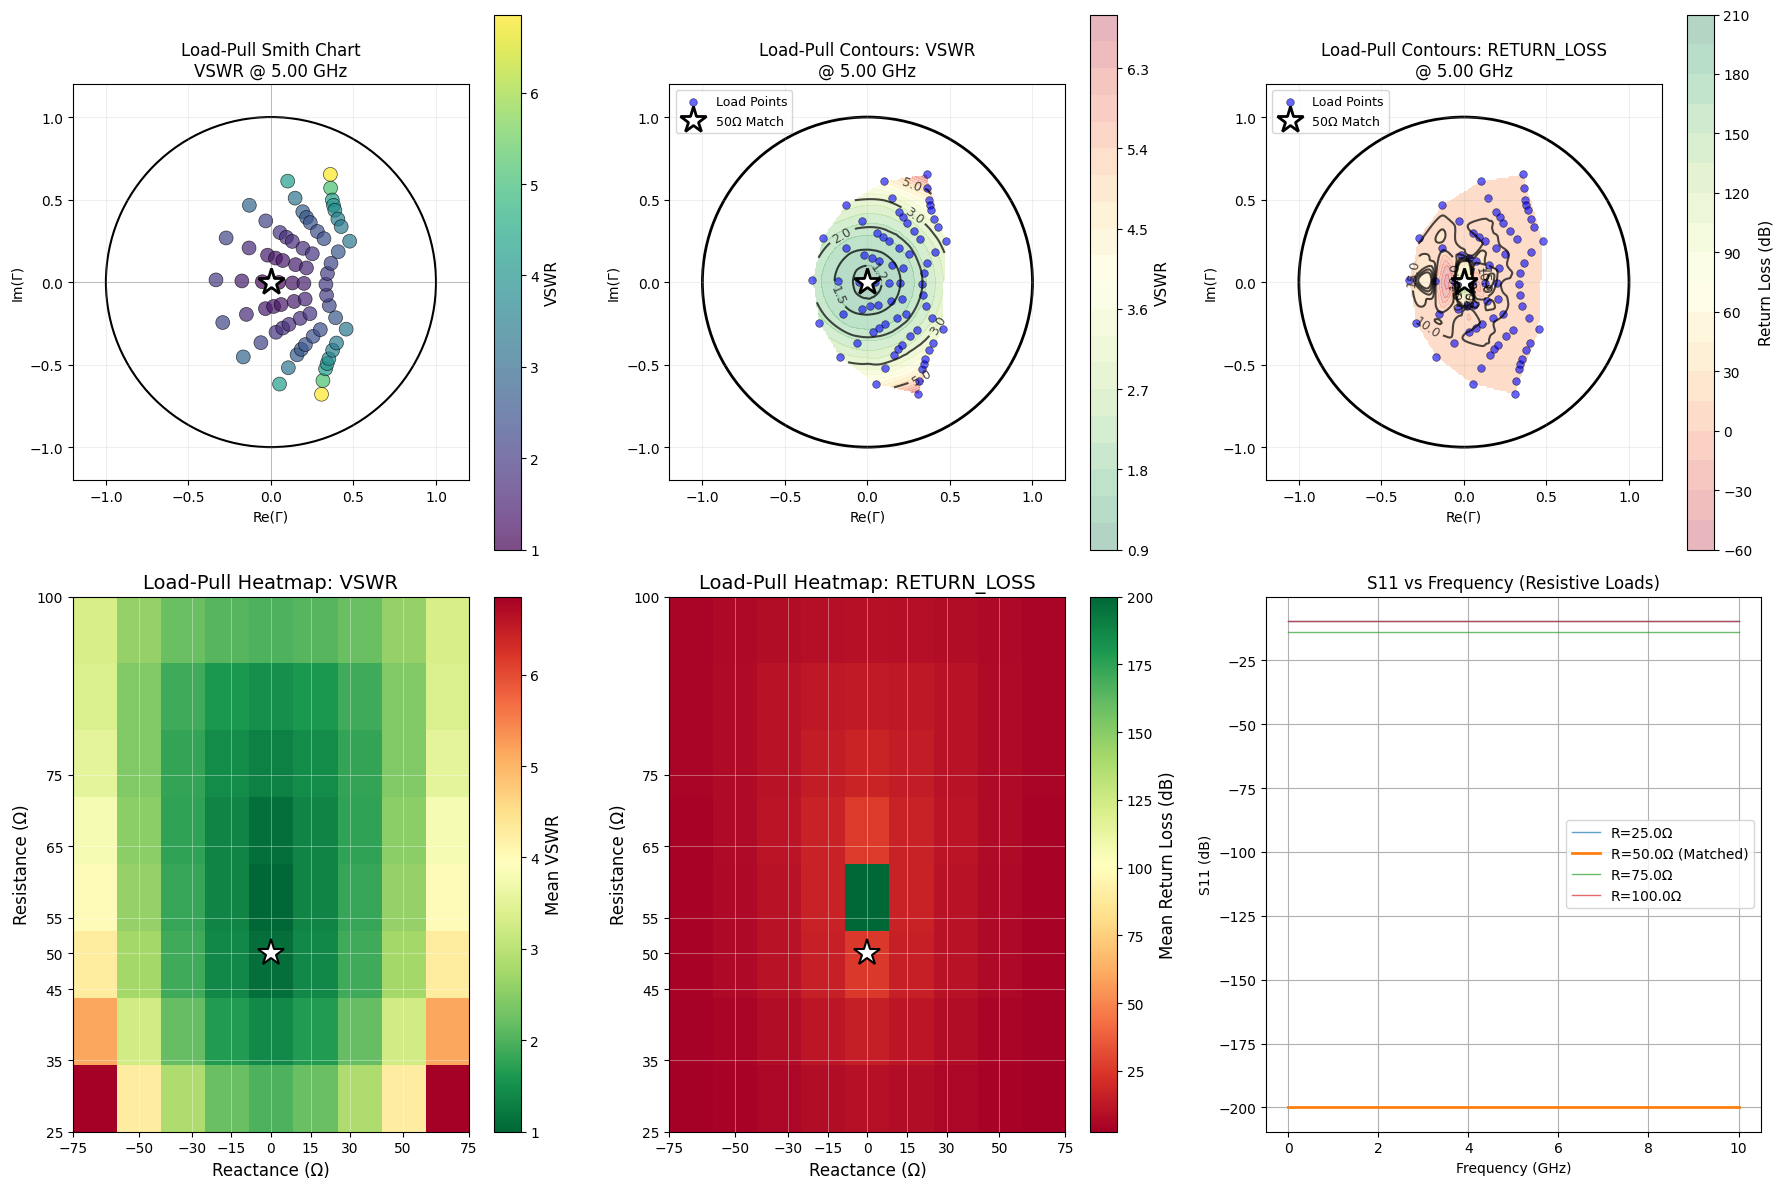

In [33]:
# Comprehensive load-pull visualization
loadpull_analyzer.plot_loadpull_summary(freq_idx=50)  # Middle frequency
plt.show()

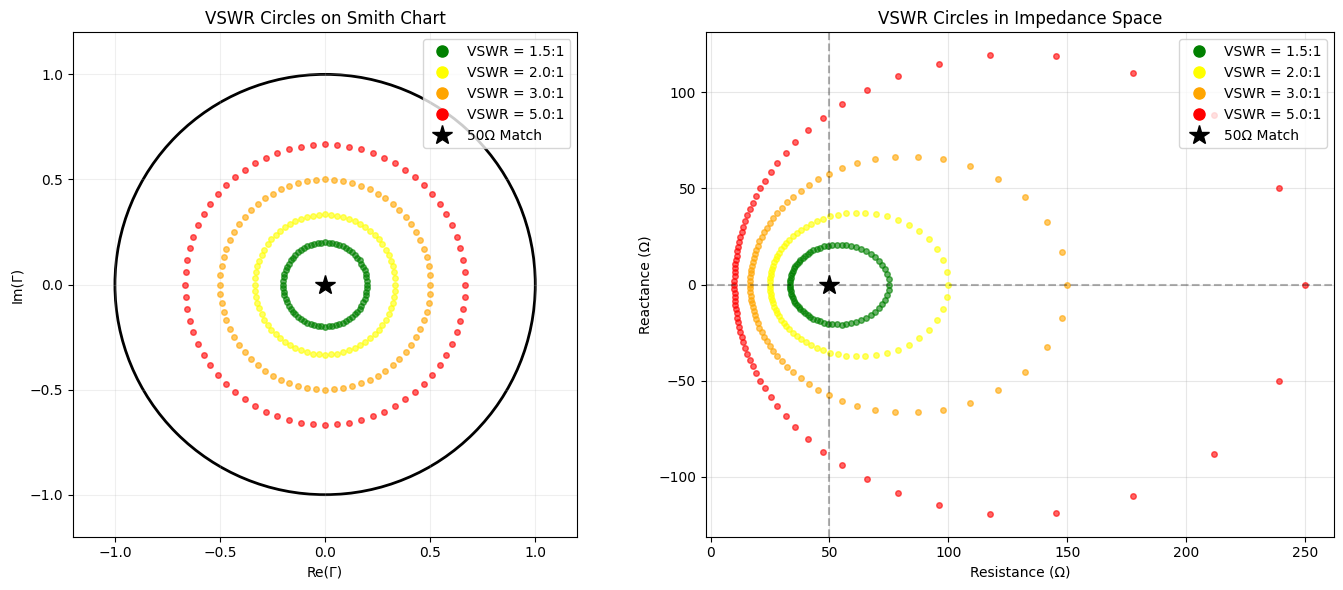

In [34]:
# Create multiple VSWR circles for visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# VSWR circle sweep
vswr_values = [1.5, 2.0, 3.0, 5.0]
colors = ['green', 'yellow', 'orange', 'red']

ax = axes[0]
# Draw Smith chart
from matplotlib.patches import Circle
ax.add_patch(Circle((0, 0), 1, fill=False, edgecolor='black', linewidth=2))
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')

for vswr, color in zip(vswr_values, colors):
    vswr_network_set = tuner.sweep_vswr_circle(vswr, num_points=72)
    
    # Plot on Smith chart
    for net in vswr_network_set:
        s11 = net.s[0, 0, 0]  # First frequency point
        ax.plot(s11.real, s11.imag, 'o', color=color, markersize=4, alpha=0.6)
    
    # Add label
    gamma_mag = (vswr - 1) / (vswr + 1)
    ax.plot([], [], 'o', color=color, markersize=8, label=f'VSWR = {vswr}:1')

ax.plot(0, 0, 'k*', markersize=15, label='50Ω Match')
ax.set_xlabel('Re(Γ)')
ax.set_ylabel('Im(Γ)')
ax.set_title('VSWR Circles on Smith Chart')
ax.legend()
ax.grid(True, alpha=0.2)

# Impedance view
ax = axes[1]
for vswr, color in zip(vswr_values, colors):
    vswr_network_set = tuner.sweep_vswr_circle(vswr, num_points=72)
    
    for net in vswr_network_set:
        z = net.z[0, 0, 0]  # First frequency point
        ax.plot(z.real, z.imag, 'o', color=color, markersize=4, alpha=0.6)
    
    ax.plot([], [], 'o', color=color, markersize=8, label=f'VSWR = {vswr}:1')

ax.plot(50, 0, 'k*', markersize=15, label='50Ω Match')
ax.set_xlabel('Resistance (Ω)')
ax.set_ylabel('Reactance (Ω)')
ax.set_title('VSWR Circles in Impedance Space')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=50, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Accessing individual analyzers:

Found matched load at index 31:
One-Port Network Analysis: LoadPull_Load_Z50.0+0.0j

Frequency Range:
  Min Frequency:     0.0000 GHz
  Max Frequency:     10.0000 GHz
  Frequency Span:    10.0000 GHz
  Number of Points:  101
  Frequency Step:    100.0000 MHz
  Z0:                50.00+0.00j Ω
  DC Extrapolated:   False
  Noise Reference:   False

S11 Characteristics:
  Best Match (S11):  -200.00 dB @ 0.000 GHz
  Worst Match (S11): -200.00 dB @ 0.000 GHz
  Mean S11:          -200.00 dB

Return Loss:
  Best RL:           200.00 dB
  Worst RL:          200.00 dB
  Mean RL:           200.00 dB

VSWR:
  Minimum VSWR:      1.000:1
  Maximum VSWR:      1.000:1
  Mean VSWR:         1.000:1

Bandwidth (Return Loss > threshold):
  RL > 10 dB:        10.000 GHz
  RL > 15 dB:        10.000 GHz
  RL > 20 dB:        10.000 GHz

Group Delay:
  Mean:              0.000 ns


/home/ukde/.pyenv/versions/SB/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


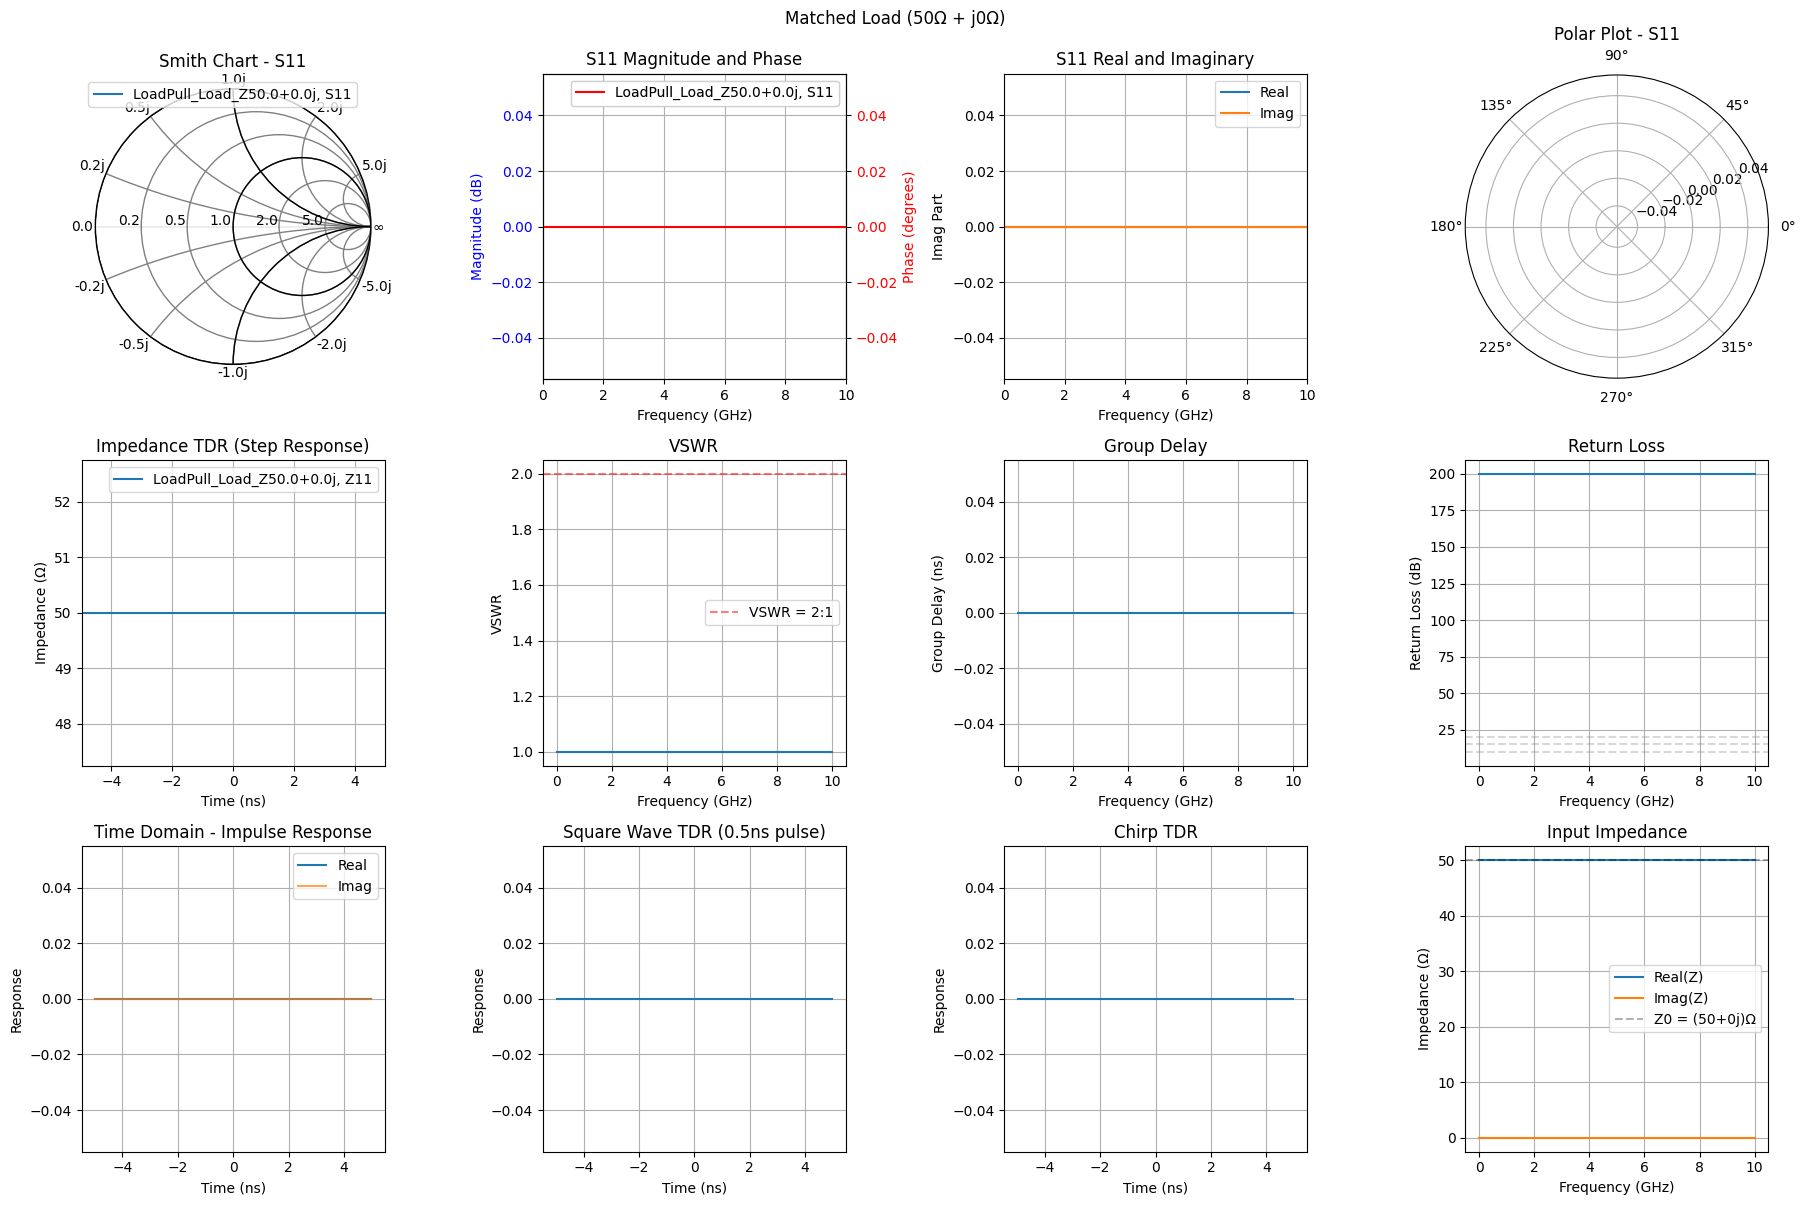

In [35]:
# Access individual analyzers from the set
print("Accessing individual analyzers:")

# Find the matched load (50Ω, 0Ω)
for i, analyzer in enumerate(loadpull_analyzer):
    if abs(analyzer.network.params['R'] - 50) < 0.1 and abs(analyzer.network.params['X']) < 0.1:
        print(f"\nFound matched load at index {i}:")
        analyzer.summary()
        
        # Plot just this one
        fig = analyzer.plot_all()
        plt.suptitle('Matched Load (50Ω + j0Ω)', y=1.00)
        plt.show()
        break